### **Topic 0: Discovering Top-k periodic high-utility itemsets from uncertain databases**


### **1. Problem Definition**


In [1]:
import random
random.seed(42)
import datetime
import heapq
from dataclasses import dataclass
from collections import namedtuple
import os
import time
import matplotlib.pyplot as plt
import psutil

In [2]:
class Item:
    """
    Represents an item with a name, utility value, and transaction weighted utility (TWU).

    Attributes:
        item (str): The name of the item.
        utility (int): The utility value of the item.
        _twu (int): The transaction weighted utility

    Methods:
        twu (property):
            - Getter: Returns the Transaction Weighted Utility (TWU) of the item.
            - Setter: Sets the Transaction Weighted Utility (TWU) of the item.
        __repr__:
            - Returns a string representation of the item (its name).
        __eq__:
            - Compares two `Item` objects for equality based on their name and utility value.
        __hash__:
            - Returns a hash value for the item, allowing it to be used in hash-based collections.
    """
    def __init__(self, item: str, utility: int):
        self.item = item
        self.utility = utility
        self._twu = 0

    @property
    def twu(self) -> int:
        """int: Gets or sets the Transaction Weighted Utility (TWU) of the item."""
        return self._twu

    @twu.setter
    def twu(self, value: int) -> None:
        self._twu = value

    def __repr__(self):
        """Returns a string representation of the item (its name)."""
        return f"{self.item}"

    def __eq__(self, other):
        """Checks equality between two items based on their name and utility."""
        if isinstance(other, Item):
            return self.item == other.item and self.utility == other.utility
        return False

    def __hash__(self):
        """Provides a hash value for the item for use in hash-based collections."""
        return hash((self.item, self.utility))


def check_order_condition(a: Item, b: Item) -> bool:
    """
    This function to check two item a > b or not

    Args:
        a (Item): an item
        b (Item): an item

    Returns:
        bool: return a > b
    """
    if a.utility * b.utility < 0:
        return a.utility < b.utility
    elif a.utility * b.utility > 0:
        if a.twu == b.twu:
            if a.utility == b.utility:
                return a.item > b.item
            return b.utility > a.utility
        return a.twu > b.twu
    return False


def check_order_item_and_set(item: Item, item_set: set[Item]) -> bool:
    """
    This function is used to check an item > item-set or not.
    
    Example: a > {b, c} ?
    
    Args:
        item (Item): an item
        item_set (set[Item]): an item set

    Returns:
        bool: return item > item_set
    """
    for i in item_set:
        if check_order_condition(item, i) == False:
            return False
    return True


class TransItem:
    """
    Represents an item within a transaction, including its quantity and probability.

    Attributes:
        item (Item): The item object representing the item.
        quantity (int): The quantity of the item in the transaction.
        probability (float): The probability of the item's occurrence in the transaction.

    Example:
        transItem1 = TransItem(a, 5, 0.7)
    """

    def __init__(self, item: Item, quantity: int, probability: float):
        self.item = item
        self.quantity = quantity
        self.probability = probability

    def __repr__(self):
        return f"{self.item},{self.quantity},{self.probability}"

In [3]:
Periodic = namedtuple("Periodic", ["min_per", "max_per", "avg_per"])

@dataclass
class Utilities:
    tid: int
    pro: float
    pu: int
    nu: int
    ru: int

In [4]:
class Transaction:
    """
        Represents a transaction consisting of multiple items, each associated with
        quantity and probability.

        Attributes:
            id (int): The unique identifier of the transaction.
            trans_items_list (list[Item]): A list of items included in the transaction.
            trans_items_dict (dict[Item, tuple[int, float]]): A dictionary mapping each
                item to its quantity and probability.

        Methods:
            __repr__():
                Returns a string representation of the transaction, showing the ID, items,
                and their quantities and probabilities.

            contains_item_set(item_set: set[Item]) -> bool:
                Checks if the transaction contains all items in the given item set.

            get_quantity_of_item(item: Item) -> int:
                Returns the quantity of the specified item in the transaction.

            get_probability_of_item(item: Item) -> float:
                Returns the probability of the specified item in the transaction.

            get_positive_utility_of_trans() -> int:
                Calculates the positive utility of the transaction by summing the utilities
                of all items with positive utility values.

            get_items() -> set[Item]:
                Returns a set of all items in the transaction.

            get_probability_of_item_set(item_set: set[Item]) -> float:
                Calculates the total probability of a given item set within the transaction.

            get_positive_utility_of_item_set(item_set: set[Item]) -> int:
                Calculates the positive utility of the specified item set.

            get_negative_utility_of_item_set(item_set: set[Item]) -> int:
                Calculates the negative utility of the specified item set.

            get_utility_of_item_set(item_set: set[Item]) -> int:
                Calculates the total utility of the specified item set.

            sort_trans_items_by_twu_and_utility() -> None:
                Sorts the items in the transaction based on their TWU and utility values.

            get_remaining_utility_of_item_set(item_set: list[Item]) -> int:
                Calculates the remaining utility of items in the transaction after the
                last item in the given item set.

        Private Methods:
            _calculate_utility(item_set: set[Item], condition: callable) -> int:
                A helper method to calculate utility of an item set based on a specified
                condition applied to the utility values.

        Example:
            a = Item("a", 3)
            b = Item("b", 6)
            
            trans_items = [
                TransItem(a, 1, 0.3),
                TransItem(b, 2, 0.6),
            ]
            
            trans1 = Transaction(1, trans_items)
    """
    def __init__(self, id: int, trans_items: list[TransItem]):
        self.id = id
        self.trans_items_list = [trans_item.item for trans_item in trans_items]
        self.trans_items_dict = {
            trans_item.item: (trans_item.quantity, trans_item.probability)
            for trans_item in trans_items
        }

    def __repr__(self):
        return f"Transaction(id={self.id}, items={list(self.trans_items_dict.keys())}, quantities={list(self.trans_items_dict.values())})"

    def contains_item_set(self, item_set: set[Item]) -> bool:
        # Check directly against the dictionary keys
        return item_set.issubset(self.trans_items_dict.keys())

    def get_quantity_of_item(self, item: Item) -> int:
        # Access quantity directly from the dictionary
        return self.trans_items_dict.get(item, (0, 0))[0]

    def get_probability_of_item(self, item: Item) -> float:
        # Access probability directly from the dictionary
        return self.trans_items_dict.get(item, (0, 0))[1]

    def get_positive_utility_of_trans(self):
        put = 0
        positive_item = {item for item in self.get_items() if item.utility > 0}
        for item in positive_item:
            put += item.utility * self.get_quantity_of_item(item)
        return put

    def get_items(self) -> set[Item]:
        return set(self.trans_items_dict.keys())

    def get_probability_of_item_set(self, item_set: set[Item]) -> float:
        if not self.contains_item_set(item_set):
            return 0.0
        total_probability = 1.0
        for item in item_set:
            total_probability *= self.get_probability_of_item(item)
        return total_probability

    def _calculate_utility(self, item_set: set[Item], condition: callable) -> int:
        total_utility = 0
        for item in item_set:
            quantity = self.get_quantity_of_item(item)
            if condition(item.utility):
                total_utility += item.utility * quantity
        return total_utility

    def get_positive_utility_of_item_set(self, item_set: set[Item]) -> int:
        return self._calculate_utility(item_set, lambda utility: utility > 0)

    def get_negative_utility_of_item_set(self, item_set: set[Item]) -> int:
        return self._calculate_utility(item_set, lambda utility: utility < 0)

    def get_utility_of_item_set(self, item_set: set[Item]) -> int:
        return self._calculate_utility(item_set, lambda utility: True)

    def sort_trans_items_by_twu_and_utility(self) -> None:
        def sort_key(item: Item) -> tuple:
            return (0 if item.utility > 0 else 1, item.twu, -item.utility, item.item)

        self.trans_items_list.sort(key=sort_key)

    def get_remaining_utility_of_item_set(self, item_set: list[Item]) -> int:
        ru = 0
        if item_set:
            last_item = item_set[-1]
            index = self.trans_items_list.index(last_item)
            for i in range(index + 1, len(self.trans_items_list)):
                item = self.trans_items_list[i]
                if item.utility > 0 and item not in item_set:
                    quantity = self.trans_items_dict[item][0]
                    ru += item.utility * quantity
        else:
            for i in range(len(self.trans_items_list)):
                item = self.trans_items_list[i]
                if item.utility > 0:
                    quantity = self.trans_items_dict[item][0]
                    ru += item.utility * quantity
        return ru

In [5]:
class AbstractList:
    """
    Represents an abstract list containing a set of items and their associated utility values.

    This class provides methods to calculate various utility metrics (e.g., positive utility,
    negative utility, remaining utility) and to perform equality and hashing operations.

    Attributes:
        item_set (set[Item]): A set of items represented by this abstract list.
        utility_values (list[Utilities]): A list of `Utilities` objects containing
                                          utility-related information for the items.

    Methods:
        get_ru() -> int:
            Calculates the total remaining utility (RU) for all items in the list.

        get_pu() -> int:
            Calculates the total positive utility (PU) for all items in the list.

        get_nu() -> int:
            Calculates the total negative utility (NU) for all items in the list.

        get_pro() -> float:
            Calculates the total probability (PRO) for all items in the list.

        get_utility() -> int:
            Calculates the combined utility (PU + NU) for all items in the list.

        __repr__() -> str:
            Returns a string representation of the abstract list, including its items
            and utility values.

        __eq__(other: AbstractList) -> bool:
            Compares two AbstractList objects for equality based on their item sets
            and utility values.

        __hash__() -> int:
            Generates a hash value for the AbstractList, enabling it to be used in
            hash-based collections (e.g., sets, dictionaries).

    Example:
        abList = AbstractList({a, b}, [Utilities(1, 2, 3, 4)])
    """
    def __init__(self, item_set: set["Item"], utility_values: list["Utilities"]):
        self.item_set = item_set
        self.utility_values = utility_values

    def get_ru(self) -> int:
        """
        Calculates the total remaining utility (RU) for all items in the list.

        Returns:
            int: The sum of the remaining utility (RU) values for all items.
        """
        return sum(i.ru for i in self.utility_values)

    def get_pu(self) -> int:
        """
        Calculates the total positive utility (PU) for all items in the list.

        Returns:
            int: The sum of the positive utility (PU) values for all items.
        """
        return sum(i.pu for i in self.utility_values)

    def get_nu(self) -> int:
        """
        Calculates the total negative utility (NU) for all items in the list.

        Returns:
            int: The sum of the negative utility (NU) values for all items.
        """
        return sum(i.nu for i in self.utility_values)

    def get_pro(self) -> float:
        """
        Calculates the total probability (PRO) for all items in the list.

        Returns:
            float: The sum of the probability (PRO) values for all items.
        """
        return sum(i.pro for i in self.utility_values)

    def get_utility(self) -> int:
        """
        Calculates the combined utility (PU + NU) for all items in the list.

        Returns:
            int: The total utility, which is the sum of PU + NU for all items.
        """
        return sum(i.pu + i.nu for i in self.utility_values)

    def __repr__(self):
        items_str = ", ".join(str(item) for item in self.item_set)
        utility_values_str = ", \n".join(
            str(utility) for utility in self.utility_values
        )
        return f"{self.__class__.__name__}(\n  Items: [{items_str}]\n  Utility Values: \n[{utility_values_str}]\n)"

    def __eq__(self, other):
        if not isinstance(other, AbstractList):
            return False
        return (
            self.item_set == other.item_set
            and self.utility_values == other.utility_values
        )

    def __hash__(self):
        return hash(frozenset(self.item_set)) ^ hash(tuple(self.utility_values))


class PNUList(AbstractList):
    """
    Represents a PNUList, which is a specialized version of AbstractList. This class inherits from AbstractList.

    Attributes:
        Inherits all attributes from AbstractList.

    Methods:
        Inherits all methods from AbstractList.

    Example:
        pnuList = PNUList({a, b}, [Utilities(1, 2, 3, 4)])
    """

    def __init__(self, item_set: set["Item"], utility_values: list["Utilities"]):
        super().__init__(item_set, utility_values)


class MList(AbstractList):
    """
    Represents an MList, a specialized version of AbstractList that includes
    additional properties for subsets and utilities. This class inherits from AbstractList.

    Attributes:
        item_set (set[Item]): The set of items represented by this MList.
        utility_values (list[Utilities]): A list of `Utilities` objects containing utility-related information for the items.
        subset (PNUList): A PNUList representing the subset associated with the MList.
        subset_prefix (PNUList): A PNUList representing the subset prefix.
        pu (int): The positive utility of the MList.
        ru (int): The remaining utility of the MList.

    Methods:
        __repr__() -> str:
            Returns a string representation of the MList, showing the item set,
            subset, and subset prefix.

        Inherits all other methods from AbstractList.
    """
    def __init__(
        self,
        item_set: set["Item"],
        subset: PNUList,
        subset_prefix: PNUList,
        utility_values: list["Utilities"],
        pu: int,
        ru: int,
    ):
        super().__init__(item_set, utility_values)
        self.subset = subset
        self.subset_prefix = subset_prefix
        self.pu = pu
        self.ru = ru

    def __repr__(self):
        return (
            f"MList("
            f"item_set={list(self.item_set)}, "
            f"subset={self.subset}, "
            f"subset_prefix={self.subset_prefix})"
        )

In [6]:
class PriorityQueue:
    """
    A priority queue for managing itemsets with associated utilities and periodic properties.

    Attributes:
        max_size (int): The maximum size of the priority queue.
        heap (list[tuple[int, set[Item], Periodic]]):
            A min-heap storing tuples of utility, itemset, and periodic properties.
        item_sets (set[frozenset]): A set of frozenset representations of the itemsets for quick lookup.

    Methods:
        __init__(max_size: int):
            Initializes the priority queue with a specified maximum size.

        push(utility: int, item_set: set, periodic: Periodic):
            Adds an item to the priority queue if it qualifies based on its utility.

        get_min_utility() -> int:
            Returns the minimum utility in the priority queue.

        sort() -> list[tuple[int, set[Item], Periodic]]:
            Returns a sorted list of items in descending order of utility.

        print_items():
            Prints all items in the priority queue, sorted by utility, with formatted periodic properties.

    Example:
        >>> from collections import namedtuple
        >>> Periodic = namedtuple("Periodic", ["min_per", "max_per", "avg_per"])
        >>> k = 3
        >>> pq = PriorityQueue(k=3)
        >>> pq.push(10, {"a", "b"}, Periodic(min_per=2, max_per=5, avg_per=3.5))
        >>> pq.push(15, {"c"}, Periodic(min_per=1, max_per=4, avg_per=2.0))
        >>> pq.push(8, {"d", "e"}, Periodic(min_per=3, max_per=7, avg_per=5.0))
        >>> pq.push(20, {"f"}, Periodic(min_per=2, max_per=6, avg_per=4.0))
        >>> pq.print_items()
        {'f'} : 20 : (min_per=2, max_per=6, avg_per=4.00)
        {'c'} : 15 : (min_per=1, max_per=4, avg_per=2.00)
        {'a', 'b'} : 10 : (min_per=2, max_per=5, avg_per=3.50)
        >>> pq.get_min_utility()
        10
    """

    def __init__(self, max_size: int):
        """
        Initializes the PriorityQueue with a maximum size.

        Args:
            max_size (int): The maximum number of items that the priority queue can hold.
        """
        self.max_size = max_size
        self.heap: list[tuple[int, set[Item], Periodic]] = []
        self.item_sets: set[frozenset] = set()

    def push(self, utility: int, item_set: set, periodic: Periodic):
        """
        Adds an itemset to the priority queue if it meets the criteria.

        Args:
            utility (int): The utility value of the itemset.
            item_set (set): The itemset to add.
            periodic (Periodic): The periodic properties of the itemset.

        Notes:
            - If the priority queue is not full, the itemset is added.
            - If the priority queue is full, the itemset replaces the one with the lowest utility
              if its utility is higher.
            - Duplicate itemset is not added.
        """
        fs_item_set = frozenset(item_set)
        if fs_item_set in self.item_sets:
            return

        if len(self.heap) < self.max_size:
            heapq.heappush(self.heap, (utility, item_set, periodic))
            self.item_sets.add(fs_item_set)
        else:
            if utility > self.heap[0][0]:
                removed = heapq.heappushpop(self.heap, (utility, item_set, periodic))
                self.item_sets.remove(frozenset(removed[1]))
                self.item_sets.add(fs_item_set)

    def get_min_utility(self) -> int:
        """
        Retrieves the minimum utility value in the priority queue.

        Returns:
            int: The minimum utility value, or `-inf` if the queue is empty.
        """
        if self.heap:
            return self.heap[0][0]
        return float("-inf")

    def sort(self) -> list[tuple[int, set[Item], Periodic]]:
        """
        Returns a sorted list of items in descending order of utility.

        Returns:
            list[tuple[int, set[Item], Periodic]]: The sorted list of items.
        """
        return sorted(self.heap, reverse=True)

    def print_items(self):
        """
        Prints all items in the priority queue, sorted by utility, with their periodic properties formatted.
        """
        for utility, item_set, periodic in self.sort():
            formatted_periodic = f"(min_per={periodic.min_per}, max_per={periodic.max_per}, avg_per={periodic.avg_per:.2f})"
            print(f"{item_set} : {utility} : {formatted_periodic}")

In [7]:
class TestCase:
    """
    Represents a test case with various thresholds and parameters.

    Attributes:
        n (int): Total number of elements.
        k (int): A limit or subset size.
        prob_threshold (float): Probability threshold, typically between 0 and 1.
        min_per_threshold (int): Minimum permissible value for a specific threshold.
        max_per_threshold (int): Maximum permissible value for a specific threshold.
        min_avg_threshold (int): Minimum average value threshold.
        max_avg_threshold (int): Maximum average value threshold.

    Example:
        testcase = TestCase(1000, 20, 0.02, 1, 2000, 1, 2000)
    """

    def __init__(
        self,
        n: int,
        k: int,
        prob_threshold: float,
        min_per_threshold: int,
        max_per_threshold: int,
        min_avg_threshold: int,
        max_avg_threshold: int,
    ):
        self.n = n
        self.k = k
        self.prob_threshold = prob_threshold
        self.min_per_threshold = min_per_threshold
        self.max_per_threshold = max_per_threshold
        self.min_avg_threshold = min_avg_threshold
        self.max_avg_threshold = max_avg_threshold

    def __repr__(self):
        """
        Provide a string representation of the TestCase object for debugging.
        """
        return (
            f"TestCase(n={self.n}, k={self.k}, prob_threshold={self.prob_threshold}, "
            f"min_per_threshold={self.min_per_threshold}, max_per_threshold={self.max_per_threshold}, "
            f"min_avg_threshold={self.min_avg_threshold}, max_avg_threshold={self.max_avg_threshold})"
        )

#### **Input:**

- **item_set**: `set[Item]`  
  A set of items to be analyzed.

- **database**: `list[Transaction]`  
  A list of transactions containing itemset.

- **k**: `int`  
  The number of items or frequent patterns to find, **specified by the user** 

- **probability_threshold**: `float`  
  A threshold value to filter results based on probability, **set by the user** 

- **min_periodic_threshold**: `int`  
  The minimum periodic constraint for the patterns, **defined by the user** 

- **max_periodic_threshold**: `int`  
  The maximum periodic constraint for the patterns, **defined by the user**

- **min_average_periodic_threshold**: `int`  
  The minimum average periodic constraint for the patterns, **set by the user** 

- **max_average_periodic_threshold**: `int`  
  The maximum average periodic constraint for the patterns, **specified by the user**


#### **Output:**

A set of **Top-K Itemset** with the **highest utility** that satisfy the following conditions:

- **Expected Support**:  
   Expected Support >= (Probability Threshold × Database Size)

- **Minimum Periodic Constraint**:  
   Min Periodic ≥ Min Periodic Threshold

- **Maximum Periodic Constraint**:  
   Max Periodic ≤ Max Periodic Threshold

- **Average Periodic Constraint**:  
   Min Average Periodic Threshold ≤ Average Periodic ≤ Max Average Periodic Threshold


#### **Input Example:**

In [8]:
a = Item("a", 3)
b = Item("b", 6)
c = Item("c", -3)
d = Item("d", 12)
e = Item("e", -5)
f = Item("f", -2)
g = Item("g", -1)

t1_trans_items = [
    TransItem(a, 5, 0.1),
    TransItem(b, 2, 0.3),
    TransItem(c, 1, 0.6),
    TransItem(d, 2, 0.5),
]

t2_trans_items = [
    TransItem(a, 1, 0.4),
    TransItem(c, 1, 0.2),
    TransItem(d, 1, 0.1),
    TransItem(g, 3, 0.7),
]

t3_trans_items = [
    TransItem(a, 1, 0.25),
    TransItem(c, 1, 0.03),
    TransItem(f, 1, 0.1),
]

t4_trans_items = [TransItem(a, 1, 0.8), TransItem(f, 4, 0.7), TransItem(g, 2, 0.2)]

t5_trans_items = [
    TransItem(a, 1, 0.1),
    TransItem(g, 2, 0.3),
]

t6_trans_items = [
    TransItem(b, 3, 0.5),
    TransItem(c, 2, 0.8),
    TransItem(d, 3, 0.2),
    TransItem(e, 1, 0.4),
]

t7_trans_items = [
    TransItem(c, 6, 0.0),
    TransItem(e, 4, 0.0),
]
t8_trans_items = [
    TransItem(e, 1, 0.2),
    TransItem(f, 3, 0.3),
]
t1 = Transaction(1, t1_trans_items)
t2 = Transaction(2, t2_trans_items)
t3 = Transaction(3, t3_trans_items)
t4 = Transaction(4, t4_trans_items)
t5 = Transaction(5, t5_trans_items)
t6 = Transaction(6, t6_trans_items)
t7 = Transaction(7, t7_trans_items)
t8 = Transaction(8, t8_trans_items)

### **2. Preliminaries and Formulation**


##### **2.1. Transaction Dictionary**


In [9]:
def create_transaction_dictionary(item_list: list[Item], database: list[Transaction]):
    """
    Creates a transaction dictionary mapping each item to the set of transactions in which it appears.

    Args:
        item_list (list[Item]): A list of items to include in the dictionary.
        database (list[Transaction]): A list of transactions containing item sets.

    Returns:
        trans_dict (dict[Item, set[Transaction]]): A dictionary where:
            - Keys are items from `item_list`.
            - Values are sets of transactions from the `database` that contain the respective items.

    Example:
        >>> item_list = [a, b, c]
        >>> database = [
        ...     Transaction(1, {a, b}),
        ...     Transaction(2, {b, c}),
        ... ]
        >>> create_transaction_dictionary(item_list, database)
        {
            a: {trans1},
            b: {trans1, trans2},
            c: {trans2}
        }

    Dependencies:
        - `Transaction.get_items`: Retrieves the set of items in a transaction.

    """

    trans_dict: dict[Item, set[Transaction]] = {item: set() for item in item_list}
    for trans in database:
        trans_items = trans.get_items()
        for item in trans_items:
            trans_dict.get(item, set()).add(trans)
    return trans_dict

**Example:**

In [10]:
item_list = [a]
dataset = [t1, t2, t3, t4, t5]
create_transaction_dictionary(item_list, dataset)

{a: {Transaction(id=1, items=[a, b, c, d], quantities=[(5, 0.1), (2, 0.3), (1, 0.6), (2, 0.5)]),
  Transaction(id=2, items=[a, c, d, g], quantities=[(1, 0.4), (1, 0.2), (1, 0.1), (3, 0.7)]),
  Transaction(id=3, items=[a, c, f], quantities=[(1, 0.25), (1, 0.03), (1, 0.1)]),
  Transaction(id=4, items=[a, f, g], quantities=[(1, 0.8), (4, 0.7), (2, 0.2)]),
  Transaction(id=5, items=[a, g], quantities=[(1, 0.1), (2, 0.3)])}}

##### **2.2. Periodic Pattern**


In [11]:
def create_item_transId_dict(
    item_list: list[Item], database: list[Transaction]
) -> dict[Item, list[int]]:
    """
    Creates a dictionary mapping each item to a list of transaction IDs in which it appears.

    Args:
        item_list (list[Item]): A list of items to initialize the dictionary keys.
        database (list[Transaction]): A list of transactions containing items.

    Returns:
        item_transIds (dict[Item, list[int]]): A dictionary where the keys are items, and the values are
                               lists of transaction IDs in which the corresponding item appears.
    
    Example:
        item_list: list[Item] = [a, b]
        dataset: list[Transaction] = [t1, t2, t3, t4, t5]
        create_item_transId_dict(item_list, dataset)
    """
    item_transIds = {item: list() for item in item_list}
    for trans in database:
        for item in trans.trans_items_dict.keys():
            item_transIds.get(item, list()).append(trans.id)
    return item_transIds

**Example:**

In [12]:
item_list: list[Item] = [a, b]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
create_item_transId_dict(item_list, dataset)

{a: [1, 2, 3, 4, 5], b: [1]}

In [13]:
def find_all_trans_ids_contained_item_set(
    item_set: set[Item], create_item_transId_dict: dict[Item, list[int]]
) -> list[int]:
    """
    Finds all transaction IDs that contain all items in a given item set.

    Args:
        item_set (set[Item]): A set of items for which to find the containing transaction IDs.
        create_item_transId_dict (dict[Item, list[int]]): A dictionary mapping each item to a list
                                                         of transaction IDs where it appears.

    Returns:
        trans_ids (list[int]): A sorted list of transaction IDs that contain all items in the item set.
                   Returns an empty list if no such transactions exist.
    """
    trans_ids = list()

    # Iterate through each item in the item set
    for item in item_set:
        if not trans_ids:
            # Initialize with transaction IDs of the first item
            trans_ids = set(create_item_transId_dict.get(item, set()))
            continue
        # Perform intersection with transaction IDs of the current item
        trans_ids &= set(create_item_transId_dict.get(item, set()))

    # Return sorted transaction IDs or an empty list if no intersection exists
    return sorted(trans_ids) if trans_ids else []

**Example:**

In [14]:
item_set = {a, b}
dataset: list[Transaction] = [t1, t2, t3, t4]
trans_dict = create_item_transId_dict(item_list, dataset)
find_all_trans_ids_contained_item_set(item_set, trans_dict)

[1]

In [15]:
def find_min_max_avg_periodic_of_item_set(
    item_set: set[Item], db: list[Transaction], item_transId_dict: dict[Item, list[int]]
) -> Periodic:
    """
    Calculates the min_per, max_per, and avg_per of an itemset within a database.

    Args:
        item_set (set[Item]): A set of items whose periodicity is to be calculated.
        db (list[Transaction]): The list of transactions in the database.
        item_transId_dict (dict[Item, list[int]]): A dictionary mapping each item to the list of transaction
            IDs where it appears.

    Returns:
        per (Periodic): A `Periodic` object containing:
            - `min_per`: The minimum periodicity.
            - `max_per`: The maximum periodicity.
            - `avg_per`: The average periodicity.

    Example:
        >>> item_set = {a, b}
        >>> db = [t1, t2, t3, t4, t5]
        >>> item_transId_dict = {
        ...     Item("a"): [1, 3, 5],
        ...     Item("b"): [1, 2, 5]
        ... }
        >>> find_min_max_avg_periodic_of_item_set(item_set, db, item_transId_dict)
        Periodic(min_per=1, max_per=2, avg_per=1.75)

    Notes:
        - If no transactions contain all items in the itemset, a default `Periodic(0, 0, 0)` is returned.
        - The calculation includes a final periodicity from the last transaction to the end of the database.

    Dependencies:
        - `find_all_trans_ids_contained_item_set`: Retrieves transaction IDs containing all items in the itemset.
        - `Periodic`: A class representing periodicity metrics.

    """
    # Find transaction IDs containing all items in the item set
    trans_ids = find_all_trans_ids_contained_item_set(item_set, item_transId_dict)
    if not trans_ids:
        return Periodic(0, 0, 0)

    # Initialize periodicity metrics
    m = len(trans_ids)
    max_per, min_per, total_per = 0, float("inf"), 0
    prev = 0

    # Calculate periodicity between successive transaction IDs
    for _, trans_id in enumerate(trans_ids):
        per = trans_id - prev
        max_per = max(max_per, per)
        min_per = min(min_per, per)
        total_per += per
        prev = trans_id

    # Include the final gap from the last transaction to the end of the database
    final_per = len(db) - prev
    max_per = max(max_per, final_per)
    min_per = min(min_per, final_per)
    total_per += final_per

    # Calculate average periodicity
    avg_per = total_per / (m + 1)

    # Return periodicity as a Periodic object
    return Periodic(min_per, max_per, avg_per)

**Example:**

In [16]:
item_list = [a, b, c, d, e]
dataset = [t1, t2, t3, t4, t5]

# Find min_per, max_per, avg_per of item set {a, d}
item_set = {a, d}
item_transId_dict = create_item_transId_dict(item_list, dataset)
find_min_max_avg_periodic_of_item_set(item_set, dataset, item_transId_dict)

Periodic(min_per=1, max_per=3, avg_per=1.6666666666666667)

##### **2.3 Transaction Weight Utility**


In [17]:
def calculate_transaction_weight_utility(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> int:
    """
    Calculates the Transaction Weighted Utility (TWU) of a given itemset.

    The TWU is the sum of the positive utility values of all transactions that contain all items
    in the specified itemset.

    Args:
        item_set (set[Item]): The set of items for which the TWU is to be calculated.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping each item to the set of
            transactions in which it appears.

    Returns:
        twu (int): The Transaction Weighted Utility (TWU) of the given itemset.

    Example:
        >>> item_set = {a, b}
        >>> trans_dict = {
        ...     a: {t1, t2},
        ...     b: {t2, t3}
        ... }
        >>> calculate_transaction_weight_utility(item_set, trans_dict)
        20

    Notes:
        - If `item_set` is empty, the result will be `0` as no transactions will be found.
        - The function calculates the intersection of transactions for all items in the itemset
          to ensure only relevant transactions are considered.

    Dependencies:
        - `Transaction.get_positive_utility_of_trans`: Computes the positive utility of a transaction.

    """
    transaction_set: set[Transaction] = set()
    for item in item_set:
        if not transaction_set:
            transaction_set = set(trans_dict[item])
            continue
        transaction_set &= set(trans_dict[item])
    twu = 0
    for trans in transaction_set:
        twu += trans.get_positive_utility_of_trans()
    return twu

**Example:**

In [18]:
item_list = [a, b, c, d, e]
dataset = [t1, t2, t3, t4, t5]
trans_dict = create_transaction_dictionary(item_list, dataset)
item_set = {a}
print("twu({a}) = " + str(calculate_transaction_weight_utility(item_set, trans_dict)))

twu({a}) = 75


In [19]:
for item in item_list:
    item.twu = calculate_transaction_weight_utility({item}, trans_dict)
    print(str(item) + " - "+ str(item.twu))

a - 75
b - 51
c - 69
d - 66
e - 0


##### **2.4. Utility of an Itemset**


In [20]:
def calculate_utility_of_item_set_in_database(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> int:
    """
    Calculates the utility of an item set in the database.

    Args:
        item_set (set[Item]): The set of items whose utility is to be calculated.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping each item to the
            set of transactions in which it appears. 

    Returns:
        utility (int): The total utility of the item set across all transactions.
    """
    transaction_set: set[Transaction] = set()

    # Intersect transactions for all items in the item set
    for item in item_set:
        if not transaction_set:
            transaction_set = set(trans_dict[item])
            continue
        transaction_set &= set(trans_dict[item])

    # Calculate the utility of the item set in the intersected transactions
    utility = 0
    for trans in transaction_set:
        utility += trans.get_utility_of_item_set(item_set)

    return utility

**Example:**

In [21]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(item_list, dataset)

print(
    "Utility({a}) = " + str(calculate_utility_of_item_set_in_database({a}, trans_dict))
)

Utility({a}) = 27


##### **2.5 Order of items**

In [22]:
def check_order_condition(a: Item, b: Item) -> bool:
    """
    Checks the ordering condition between two items based on their utility and TWU values.

    Args:
        a (Item): The first item to compare.
        b (Item): The second item to compare.

    Returns:
        bool: `True` if the order condition holds, otherwise `False`.
    """
    if a.utility * b.utility < 0:
        return a.utility < b.utility
    elif a.utility * b.utility > 0:
        if a.twu == b.twu:
            if a.utility == b.utility:
                return a.item > b.item
            return b.utility > a.utility
        return a.twu > b.twu
    return False

**Example:**

In [23]:
print("a > c ? " + str(check_order_condition(a, c)))

a > c ? False


In [24]:
def check_order_item_and_set(item: Item, item_set: set[Item]) -> bool:
    """
    Checks whether a given item satisfies the order condition with an item-set
    
    Example: check a > {b, c} ?

    Args:
        item (Item): The item to compare against the set.
        item_set (set[Item]): A set of items to compare with the given item.

    Returns:
        bool: `True` if the given item satisfies the order condition with all items in the set,
              otherwise `False`.
    """
    for i in item_set:
        if check_order_condition(item, i) == False:
            return False
    return True

**Example:**

In [25]:
print("c > {a, b} ? " + str(check_order_item_and_set(c, {a, b})))

c > {a, b} ? True


In [26]:
def sort_items_by_twu_and_utility(items: list[Item]) -> list[Item]:
    """
    Sorts a list of items based on Transaction Weighted Utility (TWU) and utility.

    Items are sorted by the following criteria in order of priority:
        1. Items with positive utility appear before items with negative utility.
        2. Items with higher TWU values are sorted first.
        3. For items with the same TWU, those with higher utility values are sorted first.
        4. For items with the same TWU and utility, sorting is done alphabetically by item name.

    Args:
        items (list[Item]): The list of items to be sorted.

    Returns:
        list[Item]: The sorted list of items.
    """
    def sort_key(item: Item) -> tuple:
        return (0 if item.utility > 0 else 1, item.twu, -item.utility, item.item)

    return sorted(items, key=sort_key)

**Example:**

In [27]:
item_list: list[Item] = [a, b, c, d, e]
print("Before: " + str(item_list))
print("After : " + str(sort_items_by_twu_and_utility(item_list)))

Before: [a, b, c, d, e]
After : [b, d, a, e, c]


##### **2.5. Potential / Expected Pattern**


In [28]:
def calculate_probability_of_item_set_in_database(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> float:
    """
    Calculates the combined probability of an itemset across all relevant transactions in the database.

    This function computes the sum of probabilities of the given itemset across all transactions
    that contain all items in the itemset.

    Args:
        item_set (set[Item]): The set of items whose combined probability is to be calculated.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping each item to the set of
            transactions in which it appears.

    Returns:
        float: The combined probability of the itemset across relevant transactions. Returns `0.0`
        if no transactions contain all items in the itemset.

    Example:
        >>> item_set = {a, b}
        >>> trans_dict = {
        ...     a: {t1, t2, t4},
        ...     b: {t2, t3}
        ... }
        >>> calculate_probability_of_item_set_in_database(item_set, trans_dict)
        0.75

    Notes:
        - If no transactions contain all items in the itemset, the probability is `0.0`.
        - The function calculates the intersection of transactions containing each item
          to ensure only relevant transactions are considered.

    Dependencies:
        - `Transaction.get_probability_of_item_set`: Calculates the probability of a given itemset
          within a specific transaction.
    """
    transaction_set: set[Transaction] = set()

    # Intersect transactions for all items in the item set
    for item in item_set:
        if not transaction_set:
            transaction_set = set(trans_dict[item])
            continue
        transaction_set &= set(trans_dict[item])

    # If no transactions contain the full item set, return 0
    if not transaction_set:
        return 0.0

    # Calculate the combined probability for the item set
    probability = 0.0
    for trans in transaction_set:
        probability += trans.get_probability_of_item_set(item_set)

    return probability

**Example:**

In [29]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
print(
    "prob({a}) = "
    + str(calculate_probability_of_item_set_in_database({a}, trans_dict))
)

prob({a}) = 1.65


In [30]:
def calculate_probability_and_utility_of_item_set_in_database(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> tuple[float, int]:
    """
    Calculates the probability, utility of an item set
    in the database based on its transactions.

    Args:
        item_set (set[Item]): The set of items whose probability, utility, and
            remaining utility are to be calculated.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping each item
            to the set of transactions in which it appears.

    Returns:
        (p, u) (tuple[float, int]): A tuple containing:
            - p (float): The combined probability of the item set across all transactions.
            - u (int): The total utility of the item set across all transactions.
    """
    # Intersect transactions for all items in the item set
    intersection_trans = set()
    for item in item_set:
        if not intersection_trans:
            intersection_trans = set(trans_dict.get(item, set()))
            continue
        intersection_trans &= trans_dict.get(item)
    p: float = 0.0
    u: int = 0
    # Calculate the probability, utility, remaining utility for the item set
    for trans in intersection_trans:
        p += trans.get_probability_of_item_set(item_set)
        u += trans.get_utility_of_item_set(item_set)
    return p, u

**Example:**

In [31]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
prob, util = calculate_probability_and_utility_of_item_set_in_database({a}, trans_dict)
print("prob({a}) = " + str(prob))
print("util({a}) = " + str(util))

prob({a}) = 1.65
util({a}) = 27


##### **2.6. Probability - TWU - Utility Bin Array**


In [32]:
def create_prob_twu_utility_bin_array(
    item_list: set[Item], database: list[Transaction]
) -> tuple[list[float], list[int], list[int], dict[Item, int]]:
    """
    Creates arrays for probability, Transaction Weighted Utility (TWU), and utility
    for all items in the given item list based on their occurrences in the database.

    Args:
        item_list (set[Item]): The set of items to be analyzed.
        database (list[Transaction]): A list of transactions where each transaction
            provides methods to retrieve items, probabilities, and quantities.

    Returns:
        (prob_array, twu_array, utility_array, item_dict) (tuple[list[float], list[int], list[int], dict[Item, int]]):
            - prob_array (list[float]): An array where each element represents the summed
              probability of an item across all transactions.
            - twu_array (list[int]): An array where each element represents the Transaction
              Weighted Utility (TWU) of an item.
            - utility_array (list[int]): An array where each element represents the total
              utility of an item (calculated as quantity * utility).
            - item_dict (dict[Item, int]): A dictionary mapping each item to its index in
              the arrays for fast access.
    """
    n = len(item_list)
    # Initialize arrays to store TWU, probability, and utility for each item
    twu_array: list[int] = [0 for _ in range(n)]
    prob_array: list[float] = [0.0 for _ in range(n)]
    utility_array: list[int] = [0 for _ in range(n)]

    # Map each item to an index in the arrays for efficient lookups
    item_dict = {item: idx for idx, item in enumerate(item_list)}

    # Iterate through all transactions to compute values
    for trans in database:
        # Get the Positive Utility (PTU) of the current transaction
        ptu = trans.get_positive_utility_of_trans()

        # Update TWU, probability, and utility for each item in the transaction
        for item in trans.get_items():
            index = item_dict.get(item, -1)  # Get the index of the item in the arrays
            if index != -1:  # If the item exists in the item_dict
                twu_array[index] += ptu  # Add transaction's PTU to the item's TWU
                prob_array[index] += trans.get_probability_of_item(
                    item
                )  # Add probability
                utility_array[index] += (
                    trans.get_quantity_of_item(item) * item.utility
                )  # Add utility

    # Return the computed arrays and the item dictionary
    return prob_array, twu_array, utility_array, item_dict

**Example:**

In [33]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)

prob_arr, twu_arr, util_arr, _ = create_prob_twu_utility_bin_array(item_list, dataset)
print(item_list)
print(util_arr)
print(twu_arr)

[a, b, c, d, e]
[27, 12, -9, 36, 0]
[75, 51, 69, 66, 0]


##### **2.7 Remaining Utility**


In [34]:
def calculate_remaining_utility_of_item_set_in_database(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> int:
    """
    Calculates the remaining utility of an item set in the database.

    The remaining utility of an item set is the sum of the remaining utilities
    in all transactions where the item set appears.

    Args:
        item_set (set[Item]): The set of items whose remaining utility is to be calculated.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping each item to the
            set of transactions in which it appears. This dictionary helps to efficiently
            find transactions that contain the given item set.

    Returns:
        ru (int): The total remaining utility of the item set across all relevant transactions.
    """
    transaction_set: set[Transaction] = set()

    # Find the intersection of transactions that contain all items in the item set
    for item in item_set:
        if not transaction_set:
            transaction_set = set(
                trans_dict[item]
            )  # Initialize with transactions of the first item
            continue
        transaction_set &= set(
            trans_dict[item]
        )  # Perform intersection with subsequent item transactions

    # Calculate the remaining utility for the item set in the intersected transactions
    utility = 0
    for trans in transaction_set:
        # Add the remaining utility of the item set in the current transaction
        utility += trans.get_remaining_utility_of_item_set(
            sort_items_by_twu_and_utility(item_set)
        )

    # Return the total remaining utility
    return utility

**Example:**

In [35]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
for trans in dataset:
    trans.sort_trans_items_by_twu_and_utility()
item_set = {a}
print(
    "ru({a}) = "
    + str(calculate_remaining_utility_of_item_set_in_database(item_set, trans_dict))
)

ru({a}) = 0


##### **2.8 Local Utility**


In [36]:
def calculate_local_utility(
    alpha: set[Item], item: Item, database: list[Transaction]
) -> int:
    """
    Calculates the local utility (LU) of an item combined with an item set (alpha) in the database.

    Args:
        alpha (set[Item]): The prefix item set (alpha) to calculate the utility for.
        item (Item): The item to be combined with alpha for utility calculation.
        database (list[Transaction]): A list of transactions 

    Returns:
        lu (int): The total local utility (LU) of the combined item set (alpha | {item}) across all relevant transactions.
    """
    lu = 0

    # Sort the prefix item set (alpha) by TWU and utility
    sorted_alpha = sort_items_by_twu_and_utility(alpha)

    # Iterate through all transactions in the database
    for trans in database:
        # Check if the transaction contains the combined item set (alpha | {item})
        if trans.contains_item_set(alpha | {item}):
            # Add the utility of alpha and the remaining utility of sorted alpha
            lu += trans.get_utility_of_item_set(
                alpha
            ) + trans.get_remaining_utility_of_item_set(sorted_alpha)

    # Return the total local utility
    return lu

**Example:**

In [37]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
print("lu({}, a) = " + str(calculate_local_utility(set(), a, dataset)))

lu({}, a) = 75


##### **2.9 Subtree Utility**

In [38]:
def calculate_subtree_utility(
    alpha: set[Item],
    item: Item,
    beta_db: set[Transaction],
    trans_dict: dict[Item, set[Transaction]],
) -> int:
    """
    Calculates the subtree utility (SU) of an item combined with an item set (alpha)
    within a subset of the database.

    Args:
        alpha (set[Item]): The prefix item set (alpha) for utility calculation.
        item (Item): The item to be combined with alpha.
        beta_db (set[Transaction]): The subset of transactions (beta database) relevant for calculation.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping each item to the
            set of transactions in which it appears.

    Returns:
        su (int): The total subtree utility (SU) of the combined item set (alpha | {item}) across all relevant transactions.
    """
    # Retrieve the set of transactions containing the item
    item_trans: set[Transaction] = set(trans_dict.get(item))

    # Find the intersection of transactions containing the item and those in beta_db
    general_trans: set[Transaction] = item_trans & beta_db

    # Initialize subtree utility
    su = 0

    # Sort the prefix item set (alpha) by TWU and utility
    sorted_alpha = sort_items_by_twu_and_utility(alpha)

    # Check the order condition if alpha is non-empty
    if not alpha or check_order_condition(item, sorted_alpha[-1]):
        for trans in general_trans:
            # Add utility contributions from alpha, item, and remaining utility of item
            su += (
                trans.get_utility_of_item_set(alpha)
                + trans.get_utility_of_item_set({item})
                + trans.get_remaining_utility_of_item_set([item])
            )

    # Return the total subtree utility
    return su

**Example:**

In [39]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
for trans in dataset:
    trans.sort_trans_items_by_twu_and_utility()
print(
    "su({a}, c) = " + str(calculate_subtree_utility({a}, c, set(dataset), trans_dict))
)

su({a}, c) = 12


##### **2.10 Local & Subtree Utility Bin Array**


In [40]:
def create_local_utility_bin_array(
    alpha: set[Item], item_list: set[Item], database: list[Transaction]
) -> list[int]:
    """
    Creates a local utility (LU) array for all for all item in item_list.

    Args:
        alpha (set[Item]): The prefix item set to guide the utility calculation.
        item_list (set[Item]): The set of items for which the LU array is calculated.
        database (list[Transaction]): A list of transactions containing items and utilities.

    Returns:
        list[int]: A list of Local Utility (LU) values for each item in `item_list`.
                   The array is indexed corresponding to the items in `item_list`.
    """
    # Number of items in item_list
    n = len(item_list)

    # Initialize the LU array with zeros
    lu_array = [0 for _ in range(n)]

    # Create a mapping from items to their indices in the LU array
    item_dict = {item: idx for idx, item in enumerate(item_list)}

    # Sort the prefix item set (alpha) by TWU and utility
    sorted_alpha = sort_items_by_twu_and_utility(alpha)

    # Iterate through each transaction in the database
    for trans in database:
        # Calculate the utility and remaining utility of alpha for the transaction
        alpha_util = trans.get_utility_of_item_set(alpha)
        alpha_ru = trans.get_remaining_utility_of_item_set(sorted_alpha)

        # Update LU array for each item in the transaction
        for item in trans.get_items():
            # Get the index of the item in the LU array
            index = item_dict.get(item, -1)
            if index != -1:
                # Add the utility of alpha and the remaining utility to the LU array
                lu_array[index] += alpha_util + alpha_ru

    # Return the computed LU array
    return lu_array

**Example:**

In [41]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
print(item_list)
create_local_utility_bin_array(set(), item_list, dataset)

[a, b, c, d, e]


[75, 51, 69, 66, 0]

In [42]:
def create_subtree_utility_bin_array(
    alpha: set[Item], item_list: set[Item], database: list[Transaction]
) -> list[int]:
    """
    Creates a subtree utility (SU) array for all item in item_list.

    Args:
        alpha (set[Item]): The prefix item set to guide the subtree calculation.
        item_list (set[Item]): The set of items for which the SU array is calculated.
        database (list[Transaction]): A list of transactions containing items and utilities.

    Returns:
        list[int]: A list of Subtree Utility (SU) values for each item in `item_list`.
                   The array is indexed corresponding to the items in `item_list`.
    """
    # Number of items in item_list
    n = len(item_list)

    # Initialize the SU array with zeros
    su_array = [0 for _ in range(n)]

    # Create a mapping from items to their indices in the SU array
    item_dict = {item: idx for idx, item in enumerate(item_list)}

    # Sort the prefix item set (alpha) by TWU and utility
    sorted_alpha = sort_items_by_twu_and_utility(alpha)

    # Iterate through each transaction in the database
    for trans in database:
        # Calculate the utility of alpha for the transaction
        alpha_util = trans.get_utility_of_item_set(alpha)

        # Update SU array for each item in the transaction
        for item in trans.get_items():
            # Get the index of the item in the SU array
            index = item_dict.get(item, -1)
            if index != -1:
                # Calculate and add subtree utility for the item
                if not alpha or check_order_condition(item, sorted_alpha[-1]):
                    su_array[index] += (
                        alpha_util
                        + trans.get_utility_of_item_set({item})
                        + trans.get_remaining_utility_of_item_set([item])
                    )

    # Return the computed SU array
    return su_array

**Example:**

In [43]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
for trans in dataset:
    trans.sort_trans_items_by_twu_and_utility()
print(item_list)
create_subtree_utility_bin_array(set(), item_list, dataset)

[a, b, c, d, e]


[27, 51, -9, 54, 0]

In [44]:
def get_value_from_bin(
    item: Item, bin: list[int | float], item_dict: dict[Item, int]
) -> int | float:
    """

    This function uses a dictionary item_dict to map the item to its index in the bin array.
    If the item is not found in the dictionary, it returns a default value of 0.

    Args:
        item (Item): The item for which the value needs to be retrieved.
        bin (list[int | float]): The bin array containing values corresponding to items.
        item_dict (dict[Item, int]): A dictionary mapping each item to its index in the bin array.

    Returns:
        values (int | float): The value associated with the item in the bin array.
                     Returns 0 if the item is not found in the dictionary.
    """
    # Get the index of the item from the dictionary
    index = item_dict.get(item, -1)

    # Return the value from the bin array if the index is valid, otherwise return 0
    return bin[index] if index != -1 else 0

**Example:**

In [45]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
for trans in dataset:
    trans.sort_trans_items_by_twu_and_utility()
su_arr = create_subtree_utility_bin_array(set(), item_list, dataset)

print(item_list)
print(su_arr)
print(
    "su_arr[a] = " + str(get_value_from_bin(a, su_arr, {a: 0}))
)

[a, b, c, d, e]
[27, 51, -9, 54, 0]
su_arr[a] = 27


##### **2.11 PNU List & MList**


In [46]:
def create_pnu_lists(trans_dict: dict[Item, set[Transaction]]) -> list[PNUList]:
    """
    Creates a list of PNULists, each representing an item's utility and probability 
    values across all transactions in which it appears.

    A PNUList contains:
        - The item as a set.
        - A list of utility values (probability, positive utility, negative utility, 
          and remaining utility) for each transaction.

    Args:
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping each item to 
            the set of transactions in which it appears.

    Returns:
        list[PNUList]: A list of PNULists where each PNUList corresponds to an item 
                       and contains its utility and probability values across relevant transactions.
    """
    pnu_list = []

    # Iterate through each item and its associated transactions in trans_dict
    for item, transactions in trans_dict.items():
        utility_values_list = []  # List to store utility values for the current item

        # Create a PNUList for the current item
        pnu = PNUList({item}, utility_values_list)

        # Calculate utility values for the item in each transaction
        for trans in transactions:
            # Get utility values from the transaction
            pro = trans.get_probability_of_item_set({item})  # Probability of the item
            pu = trans.get_positive_utility_of_item_set({item})  # Positive utility of the item
            nu = trans.get_negative_utility_of_item_set({item})  # Negative utility of the item
            ru = trans.get_remaining_utility_of_item_set([item])  # Remaining utility of the item

            # Create a Utilities object to store values for the transaction
            utility_values = Utilities(trans.id, pro, pu, nu, ru)

            # Add the utility values to the list for this item
            utility_values_list.append(utility_values)

        # Add the PNUList for this item to the main list
        pnu_list.append(pnu)

    # Return the list of PNULists
    return pnu_list

**Example:**

In [47]:
item_list: list[Item] = [a, d]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
pnu_lists: list[PNUList] = create_pnu_lists(trans_dict)
print(pnu_lists)

[PNUList(
  Items: [a]
  Utility Values: 
[Utilities(tid=3, pro=0.25, pu=3, nu=0, ru=0), 
Utilities(tid=1, pro=0.1, pu=15, nu=0, ru=0), 
Utilities(tid=4, pro=0.8, pu=3, nu=0, ru=0), 
Utilities(tid=2, pro=0.4, pu=3, nu=0, ru=0), 
Utilities(tid=5, pro=0.1, pu=3, nu=0, ru=0)]
), PNUList(
  Items: [d]
  Utility Values: 
[Utilities(tid=2, pro=0.1, pu=12, nu=0, ru=3), 
Utilities(tid=1, pro=0.5, pu=24, nu=0, ru=15)]
)]


In [48]:
def find_tuple_by_trans_id(P: PNUList, target_trans_id: int) -> Utilities | None:
    """
    Finds a `Utilities` tuple in the utility values of a PNUList by transaction ID.

    Args:
        P (PNUList): The PNUList object containing utility values as a list of `Utilities` objects.
        target_trans_id (int): The transaction ID to search for.

    Returns:
        Utilities | None: The `Utilities` object with the matching transaction ID if found.
                          Returns `None` if no match is found.
    """
    # Get the list of Utilities objects from the PNUList
    utilities_list: list[Utilities] = P.utility_values

    # Iterate through each Utilities object to find the one with the matching transaction ID
    for iTuple in utilities_list:
        if iTuple.tid == target_trans_id:  # Match found
            return iTuple

    # Return None if no matching transaction ID is found
    return None

**Example:**

In [49]:
a_pnuList = pnu_lists[0]
target_trans_id = 2
print(
    "PNU_List(a) in trans2 is: "
    + str(find_tuple_by_trans_id(a_pnuList, target_trans_id))
)

PNU_List(a) in trans2 is: Utilities(tid=2, pro=0.4, pu=3, nu=0, ru=0)


In [50]:
def utility_list_construct(
    P: PNUList,
    Px: PNUList,
    Py: PNUList,
    min_util: int,
    user_prob_threshold: float,
) -> PNUList | None:
    """
    Constructs the utility list for the combined item set (Px U Py) by processing
    the utility lists of two item sets (Px and Py) with optional reference to a
    parent item set (P).

    Args:
        P (PNUList): The parent PNUList containing the utility values of the combined items' parent set.
                     It can be used for normalization or overlap calculations.
        Px (PNUList): The PNUList of the first item set.
        Py (PNUList): The PNUList of the second item set.
        min_util (int): The minimum utility threshold for the combined item set.
        user_prob_threshold (float): The minimum probability threshold for the combined item set.

    Returns:
        PNUList | None: The PNUList for the combined item set (Px ∪ Py) if it satisfies the
                        given thresholds. 
    """
    # Check if Px or Py is empty or has no utility values
    if not Px or not Py or not Px.utility_values or not Py.utility_values:
        return None

    # Combine the item sets of Px and Py
    x = Px.item_set
    y = Py.item_set
    xy = x | y

    # Initialize the utility list for the combined item set
    utilities_list: list[Utilities] = []
    Pxy = PNUList(xy, utilities_list)

    # Create dictionaries for fast lookup of utility values by transaction ID
    y_dict = {utl.tid: utl for utl in Py.utility_values}
    p_dict = (
        {utl.tid: utl for utl in P.utility_values} if P and P.utility_values else {}
    )

    # Initialize combined probability and utility
    probability = Px.get_pro()
    utility = Px.get_pu() + Px.get_ru()

    # Iterate through the utility values of Px
    for xTuple in Px.utility_values:
        yTuple = y_dict.get(xTuple.tid, None)  # Find matching utility in Py

        if yTuple:  # If both Px and Py have values for the same transaction
            if P and P.utility_values:  # If parent PNUList (P) is provided
                pTuple = p_dict.get(xTuple.tid, None)  # Find matching utility in P
                if pTuple:
                    # Calculate utility values for the combined item set
                    pro = (
                        1e-10 if pTuple.pro == 0 else pTuple.pro
                    )  # Avoid division by zero
                    xyTuple = Utilities(
                        xTuple.tid,
                        xTuple.pro * yTuple.pro / pro,
                        xTuple.pu + yTuple.pu - pTuple.pu,
                        xTuple.nu + yTuple.nu - pTuple.nu,
                        yTuple.ru,
                    )
                    utilities_list.append(xyTuple)
            else:  # If parent PNUList (P) is not provided
                xyTuple = Utilities(
                    xTuple.tid,
                    xTuple.pro * yTuple.pro,
                    xTuple.pu + yTuple.pu,
                    xTuple.nu + yTuple.nu,
                    yTuple.ru,
                )
                utilities_list.append(xyTuple)
        else:  # If there is no match in Py
            probability -= xTuple.pro
            utility -= xTuple.pu + xTuple.ru

            # Stop processing if thresholds are not met
            if probability < user_prob_threshold or utility < min_util:
                return None

    # Return the constructed PNUList for the combined item set
    return Pxy

**Example:**

In [51]:
a_pnuList = pnu_lists[0]
d_pnuList = pnu_lists[1]
ad_pnuList = utility_list_construct(None, a_pnuList, d_pnuList, 2, 0.0)
print(ad_pnuList)

PNUList(
  Items: [d, a]
  Utility Values: 
[Utilities(tid=1, pro=0.05, pu=39, nu=0, ru=15), 
Utilities(tid=2, pro=0.04000000000000001, pu=15, nu=0, ru=3)]
)


In [52]:
def mlist_construct_1(X: AbstractList, Y: MList, du: int) -> MList:
    """
    Constructs an MList object by combining the item sets of two input lists
    and initializing utility values based on the given remaining utility (du).

    Args:
        X (AbstractList): An AbstractList object representing the first list
                          of items and their utility values.
        Y (MList): An MList object representing the second list of items,
                   subsets, and their utility values.
        du (int): The dynamic upper bound value for the combined MList.

    Returns:
        MList: The newly constructed MList object that combines the item sets
               from X and Y, while retaining Y's subsets and utility values.
    """
    # Combine the item sets from X and Y
    xy_item_set: set[Item] = X.item_set | Y.item_set

    # Create a new MList object with combined item sets and initialized utility values
    mlist = MList(xy_item_set, Y.subset, Y.subset_prefix, Y.utility_values, 0, du)

    # Return the constructed MList
    return mlist

In [53]:
def mlist_construct_2(X: AbstractList, Y: PNUList, P: AbstractList, du: int) -> MList:
    """
    Constructs an MList object by combining the item sets of an AbstractList (X)
    and a PNUList (Y), while linking it to a parent AbstractList (P) and
    initializing utility values based on the given remaining utility (du).

    Args:
        X (AbstractList): An AbstractList object representing the first list
                          of items and their utility values.
        Y (PNUList): A PNUList object representing the second list of items,
                     subsets, and their utility values.
        P (AbstractList): A parent AbstractList object linked to the new MList.
        du (int): The dynamic upper bound value for the combined MList.

    Returns:
        MList: The newly constructed MList object that combines the item sets
               from X and Y, links to P, and initializes utility values.
    """
    # Combine the item sets from X and Y
    xy_item_set: set[Item] = X.item_set | Y.item_set

    # Create a new MList object with combined item sets, linking to Y and P
    mlist = MList(xy_item_set, Y, P, Y.utility_values, 0, du)

    # Return the constructed MList
    return mlist

##### **2.12 Database Projection**


In [54]:
def create_database_projection(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> set[Transaction]:
    """
    Creates a projected database by finding the intersection of transactions
    that contain all items in the given item set.

    Args:
        item_set (set[Item]): The set of items for which the projected database
                              needs to be created.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping each item
                                                  to the set of transactions in
                                                  which it appears.

    Returns:
        intersection_trans (set[Transaction]): A set of transactions that contain all items in the item set.
                          Returns an empty set if no transactions contain all items.
    """
    # Initialize an empty set to store the intersection of transactions
    intersection_trans = set()

    # Iterate through each item in the item set
    for item in item_set:
        if not intersection_trans:
            # Initialize the intersection with the transactions of the first item
            intersection_trans = set(trans_dict.get(item, set()))
            continue
        # Perform intersection with transactions containing the current item
        intersection_trans &= trans_dict.get(item, set())

    # Return the final set of intersected transactions
    return intersection_trans

**Example:**

In [55]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
print("Database Projection of {a, c} is: ")
create_database_projection({a, c}, trans_dict)

Database Projection of {a, c} is: 


{Transaction(id=1, items=[a, b, c, d], quantities=[(5, 0.1), (2, 0.3), (1, 0.6), (2, 0.5)]),
 Transaction(id=2, items=[a, c, d, g], quantities=[(1, 0.4), (1, 0.2), (1, 0.1), (3, 0.7)]),
 Transaction(id=3, items=[a, c, f], quantities=[(1, 0.25), (1, 0.03), (1, 0.1)])}

### **3. Pruning strategies**

##### **3.1 Max Periodic & Average Periodic Pruning Strategy**

Given an itemset X, 

+ If **maxPer(X) > maxPer**, then neither X nor its extensions will be a periodic pattern.

+ If `maxPer(X) ≤ max_per_threshold`, we say that X passes maxPer condition.

---

+ If **avgPer(X) > max_avg_threshold**, then neither X nor its extensions will be a periodic pattern. 

+ If `avgPer(X) ≤ max_avg_threshold`, we say that X passes maxPer condition.

##### **3.2 Transaction Weight Utility Pruning Strategy**

For any single item **i**, if TWU(**i**) < minUtility, then any itemset ***X*** containing **i** will not be a high-utility itemset.

---

**1. Calculate TWU**  

   TWU(X) = Σ<sub>X⊆T<sub>j</sub>,T<sub>j</sub>∈D</sub>PU(T<sub>j</sub>)

**2. Pruning Rule**  
   + If **TWU(X) < min_util**: Discard X.
   + If `TWU(X) >= min_util`: Retain X.

**3. Example**  
   + min_util = 25
   + TWU({a}) = 33: Retained.
   + TWU({b}) = 23: Discarded
   + TWU({c}) = 28: Retained.

---

**Benefits**
- Reduces search space.
- Focuses on potential item-sets.

##### **3.3 The Estimated Utility Co-occurrence pruning Strategy with Threshold (EUCST)**


In [56]:
def create_eucst_dict(
    sorted_item_list: list[Item],
    database: list[Transaction],
    trans_dict: dict[Item, set[Transaction]],
    min_util: int,
) -> dict[frozenset, int]:
    """
    Creates an EUCST (Efficient Utility Co-occurrence Support Threshold) dictionary.

    The function calculates the Transaction Weighted Utility (TWU) for all pairs of items
    that >= the minimum utility threshold (`min_util`).

    Args:
        sorted_item_list (list[Item]): A sorted list of items by descending TWU.
        database (list[Transaction]): A list of transactions containing item-sets.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping items to the set of
            transactions in which they appear.
        min_util (int): The minimum utility threshold to filter item pairs.

    Returns:
        eucst_dict (dict[frozenset, int]): A dictionary where keys are frozen-sets of item pairs and utility value

    Example:
        >>> sorted_item_list = [a, b, c]
        >>> database = [t1, t2, t3, t4]
        >>> trans_dict = {
        ...     a: {t1, t2},
        ...     b: {t2},
        ...     c: {t3, t4}
        ... }
        >>> min_util=15
        >>> create_eucst_dict(sorted_item_list, database, trans_dict, min_util)
        {frozenset({"a", "b"}): 16, frozenset({"a", "c"}): 18}

    Dependencies:
        - `Transaction.get_positive_utility_of_trans`: Computes the positive utility of a transaction.

    """
    
    # Calculate all positive utility of transaction in database, and store in a dictionary
    transaction_twu = {
        trans: trans.get_positive_utility_of_trans() for trans in database
    }
    # Create a dictionary with key is a item and value is a list of transaction that contains item
    eucst_dict = {}
    n = len(sorted_item_list)
    for i in range(n):
        item1 = sorted_item_list[i]
        for j in range(i + 1, n):
            item2 = sorted_item_list[j]
            # Using AND operator to get list of transaction that contains item set {item1, item2}
            relevant_transactions: set[Transaction] = trans_dict.get(
                item1, set()
            ) & trans_dict.get(item2, set())
            # Calculate sum utility in that transaction list, NOT in database
            twu = sum(transaction_twu[trans] for trans in relevant_transactions)
            if twu >= min_util:
                eucst_dict[frozenset({item1, item2})] = twu
    return eucst_dict

**Example:**

In [57]:
item_list: list[Item] = list([a, b, c, d, e])
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
min_util = 50
sorted_item_list = sort_items_by_twu_and_utility(item_list)
old_eucst = create_eucst_dict(sorted_item_list, dataset, trans_dict, 50)

print("EUCST Dictionary (min_util = 50): ")
old_eucst

EUCST Dictionary (min_util = 50): 


{frozenset({b, d}): 51,
 frozenset({a, b}): 51,
 frozenset({b, c}): 51,
 frozenset({a, d}): 66,
 frozenset({c, d}): 66,
 frozenset({a, c}): 69}

In [58]:
def update_eucst_dict(
    eucst_dict: dict[frozenset, int], min_util: int
) -> dict[frozenset, int]:
    """
    Filters an EUCST dictionary to retain only item pairs whose Transaction Weighted Utility (TWU)
    meets or exceeds a specified minimum utility threshold.

    Args:
        eucst_dict (dict[frozenset, int]): A dictionary where keys are item pairs
                                           represented as frozenset and values are their TWU.
        min_util (int): The minimum utility threshold for retaining item pairs.

    Returns:
        dict[frozenset, int]: A filtered dictionary containing only the item pairs whose TWU
                              is greater than or equal to `min_util`.
    """
    # Filter the dictionary to retain only item pairs with TWU >= min_util
    return {key: twu for key, twu in eucst_dict.items() if twu >= min_util}

**Example:**

In [59]:
new_eucst = update_eucst_dict(old_eucst, 60)
print("EUCST Dictionary (min_util = 60): ")
new_eucst

EUCST Dictionary (min_util = 60): 


{frozenset({a, d}): 66, frozenset({c, d}): 66, frozenset({a, c}): 69}

##### **3.4 The concept of Leaf Itemset Utility (LIU)**

In [60]:
def create_liu_dict(item_list: list, trans_dict: dict[Item, set[Transaction]]) -> dict[frozenset[Item], int]:
    """
    Creates a dictionary of item pairs and their corresponding utility values (LIU - Local Item Utility).

    This function calculates the utility of all pairs of items in a given list by finding common
    transactions and summing the utilities for each pair. The result is stored in a dictionary
    where keys are frozen-sets of item pairs and values are their respective utilities.

    Args:
        item_list (list[Item]): A list of items for which pairwise utilities are to be calculated.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping items to the set of
            transactions containing them.

    Returns:
        liu_dict (dict[frozenset[Item], int]): A dictionary where:
            - Keys are frozen-sets of item pairs.
            - Values are the utility values of the corresponding item pairs.

    Example:
        >>> item_list = [a, b, c]
        >>> trans_dict = {
        ...     Item("a"): {Transaction(1), Transaction(2)},
        ...     Item("b"): {Transaction(2)},
        ...     Item("c"): {Transaction(1)}
        ... }
        >>> create_liu_dict(item_list, trans_dict)
        {frozenset({"a", "b"}): 10, frozenset({"a", "c"}): 15, frozenset({"b", "c"}): 5}

    Dependencies:
        - `Transaction.get_utility_of_item_set`: Calculates the utility of a given itemset in a transaction.
    """
    n = len(item_list)
    liu_dict: dict[frozenset[Item], int] = {}
    # Generate all pairs of items using nested loops
    for i in range(n):
        for j in range(i + 1, n):
            item1 = item_list[i]
            item2 = item_list[j]

            # Retrieve transactions containing item1 and item2
            trans1 = trans_dict.get(item1, set())
            trans2 = trans_dict.get(item2, set())

            # Find common transactions for the pair
            relevant_transactions = trans1 & trans2

            # Calculate the utility of the item pair
            utility = sum(
                trans.get_utility_of_item_set({item1, item2})
                for trans in relevant_transactions
            )

            # Add the pair and its utility to the dictionary
            liu_dict[frozenset((item1, item2))] = utility

    return liu_dict

**Example:**

In [61]:
item_list: list[Item] = [a, b, c, d]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
liu_dict = create_liu_dict(item_list, trans_dict)
liu_dict

{frozenset({a, b}): 27,
 frozenset({a, c}): 12,
 frozenset({a, d}): 54,
 frozenset({b, c}): 9,
 frozenset({b, d}): 36,
 frozenset({c, d}): 30}

##### **3.5 Remaining Utility Pruning (RM)**


Let ***X*** be an itemset. 

+ If **RU(***X***) + U(***X***) < minUtility**, then ***X*** and its extensions will not be high-utility item-sets.

+ If `RU(X) + U(X) ≥ minUtility`, we say ***X*** passes RU condition.

##### **3.6 Dynamical Upper Bound**


In [62]:
def calculate_dynamic_upper_bound(
    Y: AbstractList,
    X: PNUList,
    utility_array: list[int],
    item_index_dict: dict[Item, int],
) -> int:
    """
    Calculates the dynamic upper bound (DU) for a given item set.

    Args:
        Y (AbstractList): The current AbstractList (can be PNUList or MList)
                          for which the dynamic upper bound is being calculated.
        X (PNUList): The parent PNUList containing the larger item set.
        utility_array (list[int]): An array of utility values for items.
        item_index_dict (dict[Item, int]): A dictionary mapping each item to
                                           its index in the utility array.

    Returns:
        du (int): The computed dynamic upper bound for the given item set.
    """
    # Find the item present in X but not in Y
    x = next(iter(X.item_set - Y.item_set))

    # Initialize the utility of the extra item to 0
    x_util = 0

    # Get the utility of the extra item if its utility is positive
    if x.utility > 0:
        x_util = get_value_from_bin(x, utility_array, item_index_dict)

    # Calculate the dynamic upper bound based on the type of Y
    if isinstance(Y, MList):
        # For MList, use ru and pu attributes
        return Y.ru + Y.pu + x_util
    else:
        return Y.get_ru() + Y.get_pu() + x_util

### **4. Threshold raising strategies**

##### **4.1 Positive Real Item Utility strategy**


In [63]:
def priu_pruning(utility_arr: list[int], k: int) -> int:
    """
    Determines the k-th largest utility value for pruning purposes in top-k mining.

    This function sorts the input utility array in descending order and returns:
    - The k-th largest utility value if `k` is within bounds.
    - The smallest value in the array if `k` exceeds the length of the array.
    - `0` if the input array is empty.

    Args:
        utility_arr (list[int]): A list of utility values.
        k (int): The rank of the utility value to retrieve (1-based index).

    Returns:
        int: The k-th largest utility value, the smallest value in the array, or `0` if the array is empty.

    Example:
        >>> priu_pruning([10, 5, 8, 3], 2)
        8
        >>> priu_pruning([], 1)
        0

    Notes:
        - The input list is not modified; a sorted copy is used internally.
        - The function assumes `k` is a positive integer.
    """
    # Sort the utility array in descending order
    sorted_util: list[int] = sorted(utility_arr, reverse=True)

    # If the sorted list is empty, return 0
    if not sorted_util:
        return 0

    # Return the k-th largest value if within bounds, otherwise the smallest value in the array
    return sorted_util[-1] if k > len(utility_arr) else sorted_util[k - 1]

**Example:**

In [64]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
_, _, utility_arr, _ = create_prob_twu_utility_bin_array(item_list, dataset)
print(sorted(util_arr, reverse=True))
print("2-th highest: " + str(priu_pruning(utility_arr, 2)))

[36, 27, 12, 0, -9]
2-th highest: 27


##### **4.2 Positive LIU-Exact strategy**


In [65]:
def pliue_strategy(lius: dict[frozenset[Item], int], k: int, current_min_util: int):
    """
    Updates the minimum utility threshold based on the top-k utilities from the lius dictionary.

    This function extracts utility values from the given dictionary, sorts them in descending order,
    and determines the k-th largest utility value. If the k-th utility value is greater than the current
    minimum utility threshold, the threshold is updated.

    Args:
        lius (dict[frozenset[Item], int]):
            A dictionary where keys are item sets (as frozen sets of `Item`)
            and values are their corresponding utility values.
        k (int):
            The rank of the utility value to consider (1-based index).
        current_min_util (int):
            The current minimum utility threshold to be potentially updated.

    Returns:
        new_min_util (int): The updated minimum utility threshold.

    Example:
        >>> lius = {frozenset(['a', 'b']): 10, frozenset(['c', 'd']): 5, frozenset(['d', 'e']): 15}
        >>> pliue_strategy(lius, 2, 8)
        10
        >>> pliue_strategy(lius, 3, 8)
        8

    Notes:
        - If `k` exceeds the number of utilities in `lius`, the smallest utility in the list is used.
        - This function assumes `lius` contains valid integer utility values.
    """


    piqu_liu = list()
    for _, utility in lius.items():
        piqu_liu.append(utility)

    piqu_liu.sort(reverse=True)

    max_index = len(piqu_liu) - 1 if k > len(piqu_liu) else k - 1

    if piqu_liu[max_index] > current_min_util:
        current_min_util = piqu_liu[max_index]
    return current_min_util

**Example:**

In [66]:
item_list: list[Item] = [a, b, c, d]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
liu_dict = create_liu_dict(item_list, trans_dict)
min_util = 5
print("min_util (before) = " + str(min_util))
min_util = pliue_strategy(liu_dict, 5, min_util)
print("min_util (after) = " + str(min_util))

min_util (before) = 5
min_util (after) = 12


##### **4.3 COVL strategy**

In [67]:
def covl_construct(
    sorted_list: list[Item],
    eucst_dict: dict[frozenset[Item], int],
    utility_arr: list[int],
    item_index_dict: dict[Item, int],
    trans_dict: dict[Item, set[Transaction]],
) -> list[int]:
    covl_list = list()
    """
    Constructs the COVL list, which contains utilities of item sets with coverage.

    The function iterates through a sorted list of items, calculates the utility of item pairs
    based on their transaction weighted utilization (TWU), and adjusts for coverage utilities.
    The resulting COVL list is sorted in descending order.

    Args:
        sorted_list (list[Item]): A list of items sorted in descending order by TWU.
        eucst_dict (dict[frozenset[Item], int]): A dictionary mapping item pairs (as frozen sets)
            to their TWU values.
        utility_arr (list[int]): An array of utility values for items.
        item_index_dict (dict[Item, int]): A dictionary mapping items to their indices in the utility array.
        trans_dict (dict[Item, set[Transaction]]): A dictionary mapping items to their associated transactions.

    Returns:
        list[int]: The COVL list, containing utilities of item sets, sorted in descending order.


    Dependencies:
        - `calculate_utility_of_item_set_in_database`: Computes utility for item sets.
        - `get_value_from_bin`: Retrieves utility values from the array using item indices.

    Returns:
        - A sorted list of computed utilities for overlapping item sets.
    """
    # Iterate through the sorted list of items
    for i in range(len(sorted_list)):
        x: Item = sorted_list[i]  # Current item
        coverage_list = list()  # Initialize coverage list for item x

        # Iterate through the remaining items in the sorted list
        for j in range(i + 1, len(sorted_list)):
            y: Item = sorted_list[j]  # Potential pair for item x
            xy: set[Item] = {x, y}
            key = frozenset(xy)  # Key for the item pair
            xy_twu = eucst_dict.get(key)  # Get TWU for the pair

            # Check if the TWU matches item x's TWU
            if x.twu == xy_twu:
                coverage_list.append(y)

        r = len(coverage_list)  # Size of the coverage list

        # If no items are covered, append a placeholder
        if r == 0:
            coverage_list.append(-1)
        else:
            util: int = 0  # Initialize utility value

            # Calculate utility for each covered pair
            for z in range(0, r):
                util += calculate_utility_of_item_set_in_database(
                    {x, coverage_list[z]}, trans_dict
                )

            # Subtract overlap utility based on the coverage size
            util -= (r - 1) * get_value_from_bin(x, utility_arr, item_index_dict)

            # Append the computed utility to the COVL list
            covl_list.append(util)

    # Sort the COVL list in descending order
    covl_list.sort(reverse=True)
    return covl_list

**Example:**

In [68]:
item_list: list[Item] = [a, b, c, d, e]
dataset: list[Transaction] = [t1, t2, t3, t4, t5]
trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
    item_list, dataset
)
min_util = 5
sorted_list = sort_items_by_twu_and_utility(item_list)
eucst_dict = create_eucst_dict(sorted_list, dataset, trans_dict, min_util)
_, _, utility_arr, item_dict = create_prob_twu_utility_bin_array(item_list, dataset)
print(
    "COVL: "
    + str(covl_construct(sorted_list, eucst_dict, utility_arr, item_dict, trans_dict))
)

COVL: [48, 48]


### **5. Algorithms**


##### **5.1 Based on PHMN Algorithm**


In [69]:
def phui_searching_procedure(
    PList: AbstractList,
    lists: list[AbstractList],
    current_min_util: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    user_prob_threshold: float,
    database: list[Transaction],
    eucs_dict: dict[frozenset[Item], int],
    item_transId_dict: dict[Item, list[int]],
    k: int,
    topk_queue: PriorityQueue,
):
    """
    Recursive procedure to mine Periodic High-Utility Item-sets (PHUI) with enhanced strategies.

    Args:
        PList (AbstractList): Parent list representing the prefix structure.
        lists (list[AbstractList]): Current lists of candidate item-sets for exploration.
        current_min_util (int): Current minimum utility threshold for pruning.
        min_per_threshold (int): Minimum periodicity threshold for item-sets.
        max_per_threshold (int): Maximum periodicity threshold for item-sets.
        min_avg_threshold (int): Minimum average periodicity threshold for item-sets.
        max_avg_threshold (int): Maximum average periodicity threshold for item-sets.
        user_prob_threshold (float): Minimum probability threshold for item-sets.
        db (list[Transaction]): Transaction database.
        utility_array (list[int]): Array of utility values for items.
        item_index_dict (dict[Item, int]): Dictionary mapping items to their indices in the utility array.
        eucs_dict (dict[frozenset[Item], int]): Dictionary storing TWU values of item-sets.
        item_transId_dict (dict[Item, list[int]]): Dictionary mapping items to transaction IDs.
        k (int): Maximum number of high-utility item-sets to retain.
        topk_queue (PriorityQueue): Priority queue for storing top-k high-utility item-sets.

    Returns:
        None: The results are updated directly in the `topk_queue`.

    Notes:
        - Applies utility and periodicity constraints to prune the search space.
        - Utilizes dynamic upper bound calculations to further refine candidates.
        - Recursively explores and constructs new candidate item-sets for mining.
    """
    for i in range(len(lists)):
        XList: AbstractList = lists[i]
        XList_utility = XList.get_utility()
        XList_prob = XList.get_pro()
        XList_ru = XList.get_ru()
        min_per, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
            XList.item_set, database, item_transId_dict
        )
        # Check High utility and Expected Pattern
        if (
            XList_utility >= current_min_util
            and round(XList_prob, 3) >= user_prob_threshold
        ):
            # Check Periodic Pattern
            if (
                min_per >= min_per_threshold
                and max_per <= max_per_threshold
                and avg_per >= min_avg_threshold
                and avg_per <= max_avg_threshold
            ):
                # Push new high utility item-set to queue,
                topk_queue.push(
                    XList_utility, XList.item_set, Periodic(min_per, max_per, avg_per)
                )
                # Update update min (k-th) utility if the queue is full
                if len(topk_queue.heap) == k:
                    current_min_util = topk_queue.get_min_utility()

        # Prune or continue exploration based on RU, Max, Avg Pruning
        if (
            max_per <= max_per_threshold
            and avg_per <= max_avg_threshold
            and XList_ru + XList_utility >= current_min_util
            and round(XList_prob, 3) >= user_prob_threshold
        ):
            new_lists: list[AbstractList] = list()
            for j in range(i + 1, len(lists)):
                YList: PNUList = lists[j]
                x = XList.item_set.difference(PList.item_set)
                y = YList.item_set.difference(PList.item_set)
                key = frozenset(x | y)
                twu_value = eucs_dict.get(key, -1)
                # TWU pruning
                if twu_value >= current_min_util:
                    # Construct new PNUList
                    ZList: PNUList = utility_list_construct(
                        PList, XList, YList, current_min_util, user_prob_threshold
                    )
                    if ZList:
                        new_lists.append(ZList)
            if new_lists:
                phui_searching_procedure(
                    XList,
                    new_lists,
                    current_min_util,
                    min_per_threshold,
                    max_per_threshold,
                    min_avg_threshold,
                    max_avg_threshold,
                    user_prob_threshold,
                    database,
                    eucs_dict,
                    item_transId_dict,
                    k,
                    topk_queue,
                )

##### **5.2 Based on PHMN+ Algorithm**


In [70]:
def phui_searching_procedure_plus(
    PList: AbstractList,
    lists: list[AbstractList],
    current_min_util: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    user_prob_threshold: float,
    db: list[Transaction],
    utility_array: list[int],
    item_index_dict: dict[Item, int],
    eucs_dict: dict[frozenset[Item], int],
    item_transId_dict: dict[Item, list[int]],
    k: int,
    topk_queue: PriorityQueue,
) -> None:
    """
    Recursive procedure to mine Periodic High-Utility Item-sets (PHUI) with enhanced strategies.

    Args:
        PList (AbstractList): Parent list representing the prefix structure.
        lists (list[AbstractList]): Current lists of candidate item-sets for exploration.
        current_min_util (int): Current minimum utility threshold for pruning.
        min_per_threshold (int): Minimum periodicity threshold for item-sets.
        max_per_threshold (int): Maximum periodicity threshold for item-sets.
        min_avg_threshold (int): Minimum average periodicity threshold for item-sets.
        max_avg_threshold (int): Maximum average periodicity threshold for item-sets.
        user_prob_threshold (float): Minimum probability threshold for item-sets.
        db (list[Transaction]): Transaction database.
        utility_array (list[int]): Array of utility values for items.
        item_index_dict (dict[Item, int]): Dictionary mapping items to their indices in the utility array.
        eucs_dict (dict[frozenset[Item], int]): Dictionary storing TWU values of item-sets.
        item_transId_dict (dict[Item, list[int]]): Dictionary mapping items to transaction IDs.
        k (int): Maximum number of high-utility item-sets to retain.
        topk_queue (PriorityQueue): Priority queue for storing top-k high-utility item-sets.

    Returns:
        None: The results are updated directly in the `topk_queue`.

    Notes:
        - Applies utility and periodicity constraints to prune the search space.
        - Utilizes dynamic upper bound calculations to further refine candidates.
        - Recursively explores and constructs new candidate item-sets for mining.
    """
    for i in range(len(lists)):
        XList: AbstractList = lists[i]
        x_utility = XList.get_utility()
        x_prob = XList.get_pro()
        x_ru = XList.get_ru()
        min_per, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
            XList.item_set, db, item_transId_dict
        )
        # Check high utility and expected support pattern
        if x_utility >= current_min_util and round(x_prob, 3) >= user_prob_threshold:
            # Check periodic pattern
            if (
                min_per >= min_per_threshold
                and max_per <= max_per_threshold
                and avg_per >= min_avg_threshold
                and avg_per <= max_avg_threshold
            ):
                # Push new high utility item-set to queue,
                topk_queue.push(
                    x_utility, XList.item_set, Periodic(min_per, max_per, avg_per)
                )
                # Update update min (k-th) utility if the queue is full
                if len(topk_queue.heap) == k:
                    current_min_util = topk_queue.get_min_utility()
        # Prune or continue exploration based on RU strategy, max and avg pruning
        if (
            max_per <= max_per_threshold
            and avg_per <= max_avg_threshold
            and x_ru + x_utility >= current_min_util
            and round(x_prob, 3) >= user_prob_threshold
        ):
            new_lists: list[AbstractList] = list()
            for j in range(i + 1, len(lists)):
                YList: AbstractList = lists[j]
                x: set[Item] = XList.item_set.difference(PList.item_set)
                y: set[Item] = YList.item_set.difference(PList.item_set)
                twu_value: int = eucs_dict.get(frozenset(x | y), -1)
                # Apply TWU pruning
                if twu_value >= current_min_util:
                    du = calculate_dynamic_upper_bound(
                        YList, XList, utility_array, item_index_dict
                    )
                    # Apply DU pruning
                    if du >= current_min_util:
                        if isinstance(YList, MList):
                            # Construct PNUList base on MList
                            ZList: PNUList = utility_list_construct(
                                YList.subset_prefix,
                                XList,
                                YList.subset,
                                current_min_util,
                                user_prob_threshold,
                            )
                            if ZList:
                                new_lists.append(ZList)
                        else:
                            # Construct PNUList base on PNUList
                            ZList: PNUList = utility_list_construct(
                                PList,
                                XList,
                                YList,
                                current_min_util,
                                user_prob_threshold,
                            )
                            if ZList:
                                new_lists.append(ZList)
                    else:
                        if isinstance(YList, MList):
                            # Construct MList
                            ZMlist: MList = mlist_construct_1(XList, YList, du)
                            new_lists.append(ZMlist)
                        else:
                            # Construct MList
                            ZMlist: MList = mlist_construct_2(XList, YList, PList, du)
                            new_lists.append(ZMlist)
            if new_lists:
                phui_searching_procedure_plus(
                    XList,
                    new_lists,
                    current_min_util,
                    min_per_threshold,
                    max_per_threshold,
                    min_avg_threshold,
                    max_avg_threshold,
                    user_prob_threshold,
                    db,
                    utility_array,
                    item_index_dict,
                    eucs_dict,
                    item_transId_dict,
                    k,
                    topk_queue,
                )

In [71]:
def topk_mining_based_on_PHUI(
    database: list[Transaction],
    item_list: list[Item],
    k: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    min_prob: float,
    is_plus: bool,
) -> PriorityQueue:

    """
    Searching for Top-K Periodic High-Utility Item-sets from uncertain databases with both positive and negative utilities
    Based on PHMN and PHMN+ algorithm
    Args:
        database (list[Transaction]): A list of transactions containing item-sets.
        item_list (list[Item]): A list of items to be considered for mining.
        k (int): The maximum number of high-utility item-sets to retrieve.
        min_per_threshold (int): The minimum periodicity threshold for an itemset.
        max_per_threshold (int): The maximum periodicity threshold for an itemset.
        min_avg_threshold (int): The minimum average periodicity threshold for an itemset.
        max_avg_threshold (int): The maximum average periodicity threshold for an itemset.
        min_prob (float): The minimum probability threshold for an itemset to qualify.
        is_plus (bool): If `True`, `use phui_searching_procedure_plus` to search,
                        else `phui_searching_procedure`

    Returns:
        PriorityQueue: A priority queue containing the top-k high-utility item-sets.

    Example:
        >>> database = [t1, t2, t3, t4,...]
        >>> item_list = [a, b, c, d, e]
        >>> k = 3
        >>> topk_queue = topk_mining_based_on_PHUI(
        ...     database, item_list, k, 2, 10, 1, 8, 0.2, True
        ... )
        >>> topk_queue.print_items()
    """

    # Create priority to contains top-k HUI
    topk_queue = PriorityQueue(k)
    user_prob_threshold = round(min_prob * len(database), 3)

    # Create a utility array & and a dictionary to search
    prob_arr, twu_arr, utility_arr, item_index_dict = create_prob_twu_utility_bin_array(
        item_list, database
    )
    positive_utility_arr = [u for u in utility_arr if u > 0]
    # First update min_util = the k-th highest utility value (using RIU strategy)
    current_min_util: int = priu_pruning(positive_utility_arr, k)

    # Create a list that contains all items is unqualified
    removed_list: set[Item] = set()

    # Create a diction contains item: list[transaction_id]
    item_transId_dict: dict[Item, list[int]] = create_item_transId_dict(
        item_list, database
    )
    for i in range(len(item_list)):
        _, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
            {item_list[i]}, database, item_transId_dict
        )
        if (
            max_per <= max_per_threshold
            and avg_per <= max_avg_threshold
            and twu_arr[i] >= current_min_util
            and round(prob_arr[i], 3) >= user_prob_threshold
        ):
            item_list[i].twu = twu_arr[i]
        else:
            removed_list.add(item_list[i])
    # Remove unqualified item
    new_distinct_items = [item for item in item_list if item not in removed_list]
    # Sort item list by order
    new_distinct_items = sort_items_by_twu_and_utility(new_distinct_items)

    # Remove unqualified items from transaction
    for trans in database:
        for item in removed_list:
            trans.trans_items_dict.pop(item, None)
            try:
                trans.trans_items_list.remove(item)
            except ValueError:
                pass
        trans.sort_trans_items_by_twu_and_utility()

    # Convert database - list[Transaction] into dict[Item, set[Transaction]]
    trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
        new_distinct_items, database
    )
    # Create list[AbstractList],
    pnu_lists: list[PNUList] = create_pnu_lists(trans_dict)

    # Create EUCST dict that contain twu > current_min_util of all 2-item-set
    eucst_dict: dict[frozenset[Item], int] = create_eucst_dict(
        new_distinct_items, database, trans_dict, current_min_util
    )

    # Create CUDM dict that contain utility of all 2-item-set
    cudm_dict: dict[frozenset[Item], int] = create_liu_dict(
        new_distinct_items, trans_dict
    )

    # Update and increase current_min_util
    if cudm_dict:
        cud: int = pliue_strategy(cudm_dict, k, current_min_util)
        # Update current min_util = the k-th highest utility in CUDM dict
        current_min_util = max(current_min_util, cud)

    covl: list[int] = covl_construct(
        new_distinct_items, eucst_dict, utility_arr, item_index_dict, trans_dict
    )
    # Update and increase current_min_util
    if covl:
        current_min_util = max(current_min_util, covl[min(len(covl), k) - 1])
    eucst_dict: dict[frozenset, int] = update_eucst_dict(eucst_dict, current_min_util)
    root = PNUList({}, list())
    if is_plus:
        phui_searching_procedure_plus(
            root,
            pnu_lists,
            current_min_util,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            user_prob_threshold,
            database,
            utility_arr,
            item_index_dict,
            eucst_dict,
            item_transId_dict,
            k,
            topk_queue,
        )
    else:
        phui_searching_procedure(
            root,
            pnu_lists,
            current_min_util,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            user_prob_threshold,
            database,
            eucst_dict,
            item_transId_dict,
            k,
            topk_queue,
        )
    return topk_queue

##### **5.3 Based on EFIM Algorithm**

In [72]:
def efim_global_search(
    alpha: set[Item],
    primary: list[Item],
    secondary: list[Item],
    min_util: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    user_prob_threshold: float,
    k: int,
    item_dict: dict[Item, int],
    topk_queue: PriorityQueue,
    trans_dict: dict[Item, set[Transaction]],
    item_transId_dict: dict[Item, list[int]],
    database: list[Transaction],
) -> None:
    """
    Recursive algorithm for mining top-k Periodic High-Utility Item-sets (PHUI) using
    the EFIM (Efficient High-Utility Itemset Mining) approach.

    Args:
        alpha (set[Item]): The current prefix itemset being explored.
        primary (list[Item]): List of primary items for further exploration.
        secondary (list[Item]): List of secondary items for conditional pattern mining.
        min_util (int): Minimum utility threshold for pruning.
        min_per_threshold (int): Minimum periodicity threshold for item-sets.
        max_per_threshold (int): Maximum periodicity threshold for item-sets.
        min_avg_threshold (int): Minimum average periodicity threshold for item-sets.
        max_avg_threshold (int): Maximum average periodicity threshold for item-sets.
        user_prob_threshold (float): Minimum probability threshold for item-sets.
        k (int): Maximum number of high-utility item-sets to retain.
        item_dict (dict[Item, int]): Dictionary of items and their corresponding TWU values.
        topk_queue (PriorityQueue): Priority queue for storing top-k high-utility item-sets.
        trans_dict (dict[Item, set[Transaction]]): Dictionary mapping items to the transactions they appear in.
        item_transId_dict (dict[Item, list[int]]): Dictionary mapping items to transaction IDs.
        database (list[Transaction]): List of transactions representing the database.

    Returns:
        None: The results are directly updated in the `topk_queue`.

    Notes:
        - Applies TWU-based pruning, periodicity constraints, and subtree utility projections.
        - Recursively explores and mines candidate item-sets based on the EFIM strategy.

    """
    for pri_item in primary:
        # Combine the current prefix `alpha` with the primary item
        beta: set[Item] = alpha | {pri_item}

        # Calculate utility and probability of the combined itemset
        prob, util = calculate_probability_and_utility_of_item_set_in_database(
            beta, trans_dict
        )

        # Determine periodicity metrics for the itemset
        min_per, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
            beta, database, item_transId_dict
        )

        # Check if the itemset qualifies as a top-k candidate
        if util >= min_util and round(prob, 3) >= user_prob_threshold:
            if (
                min_per >= min_per_threshold
                and max_per <= max_per_threshold
                and avg_per >= min_avg_threshold
                and avg_per <= max_avg_threshold
            ):
                # Add the itemset to the priority queue
                topk_queue.push(util, beta, Periodic(min_per, max_per, avg_per))
                # Update the minimum utility threshold if the queue is full
                if len(topk_queue.heap) == k:
                    min_util = topk_queue.get_min_utility()

        # Check if further exploration is needed
        if (
            max_per <= max_per_threshold
            and avg_per <= max_avg_threshold
            and round(prob, 3) >= user_prob_threshold
        ):
            # Get the index of the current primary item in the secondary list
            i = secondary.index(pri_item)
            if i != -1 and i + 1 < len(secondary):
                second_item = secondary[i + 1]
                # Prune based on utility and periodicity constraints
                if (
                    util < min_util
                    or round(prob, 3) < user_prob_threshold
                    or min_per < min_per_threshold
                    or max_per > max_per_threshold
                    or avg_per < min_avg_threshold
                    or avg_per > max_avg_threshold
                ) and second_item.utility < 0:
                    continue

            # Create a projected database for the combined itemset
            beta_dp: set[Transaction] = create_database_projection(beta, trans_dict)

            # Compute local utility and subtree utility arrays
            lu_arr = create_local_utility_bin_array(beta, secondary, beta_dp)
            new_primary: list[Item] = list()
            new_secondary: list[Item] = list()

            # Update secondary and primary items based on local utility
            for j in range(i + 1, len(secondary)):
                if lu_arr[j] >= min_util:
                    new_secondary.append(secondary[j])

            su_arr = create_subtree_utility_bin_array(beta, new_secondary, beta_dp)
            for j in range(len(new_secondary)):
                if su_arr[j] >= min_util:
                    new_primary.append(new_secondary[j])

            # Recursively mine new candidate item-sets
            if new_primary and new_secondary:
                efim_global_search(
                    beta,
                    new_primary,
                    new_secondary,
                    min_util,
                    min_per_threshold,
                    max_per_threshold,
                    min_avg_threshold,
                    max_avg_threshold,
                    user_prob_threshold,
                    k,
                    item_dict,
                    topk_queue,
                    trans_dict,
                    item_transId_dict,
                    database,
                )

In [73]:
def topk_mining_based_on_EFIM(
    database: list[Transaction],
    item_list: list[Item],
    k: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    min_prob: float,
) -> PriorityQueue:
    """
    Searching for Top-K Periodic High-Utility Item-sets from uncertain databases with both positive and negative utilities.
    Based on EFIM (A Highly Efficient Algorithm for High-Utility Itemset Mining) Algorithm

    Args:
        database (list[Transaction]): A list of transactions containing item-sets.
        item_list (list[Item]): A list of items to be considered for mining.
        k (int): The maximum number of high-utility item-sets to retrieve.
        min_per_threshold (int): The minimum periodicity threshold for an itemset.
        max_per_threshold (int): The maximum periodicity threshold for an itemset.
        min_avg_threshold (int): The minimum average periodicity threshold for an itemset.
        max_avg_threshold (int): The maximum average periodicity threshold for an itemset.
        min_prob (float): The minimum probability threshold for an itemset to qualify.

    Returns:
        PriorityQueue: A priority queue containing the top-k high-utility item-sets.

    Example:
        >>> database = [t1, t2, t3, t4,...]
        >>> item_list = [a, b, c, d, e]
        >>> k = 3
        >>> topk_queue = topk_mining_based_on_PHUI(
        ...     database, item_list, k, 2, 10, 1, 8, 0.2, True
        ... )
        >>> topk_queue.print_items()

    """
    if k <= 0:
        return
    # Init alpha with empty set
    alpha: set[Item] = set()
    topk_queue = PriorityQueue(k)
    current_min_util = 0
    user_prob_threshold = round(min_prob * len(database), 3)

    prob_arr, twu_arr, utility_arr, item_dict = create_prob_twu_utility_bin_array(
        item_list, database
    )
    # Get only positive item set
    positive_utility_list: list[Item] = [
        utility for utility in utility_arr if utility > 0
    ]

    # Update current_min_util = the k-th largest in utility array
    current_min_util: int = priu_pruning(positive_utility_list, k)

    # Create secondary list
    secondary = list()

    item_transId_dict: dict[Item, list[int]] = create_item_transId_dict(
        item_list, database
    )

    for i in range(len(item_list)):
        if (
            round(prob_arr[i], 3) >= user_prob_threshold
            and twu_arr[i] >= current_min_util
        ):
            _, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
                {item_list[i]}, database, item_transId_dict
            )
            if max_per <= max_per_threshold and avg_per <= max_avg_threshold:
                item_list[i].twu = twu_arr[i]
                secondary.append(item_list[i])

    # Create removed_list contains item unqualified
    removed_list = set(item_list).difference(secondary)

    # Remove those items in removed_list from database
    for trans in database:
        for item in removed_list:
            trans.trans_items_dict.pop(item, None)
            try:
                trans.trans_items_list.remove(item)
            except ValueError:
                pass
        trans.sort_trans_items_by_twu_and_utility()

    # Convert database (list[Transaction]) to trans_dict (dict[Item, set[Transaction]])
    trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
        secondary, database
    )
    # Create liu dict, to update current_min_util
    lius: dict[frozenset[Item], int] = create_liu_dict(secondary, trans_dict)
    if lius:
        current_min_util = pliue_strategy(lius, k, current_min_util)

    secondary = sort_items_by_twu_and_utility(secondary)

    eucst_dict: dict[frozenset[Item], int] = create_eucst_dict(
        secondary, database, trans_dict, current_min_util
    )
    covl: list[int] = covl_construct(
        secondary, eucst_dict, utility_arr, item_dict, trans_dict
    )
    # Update and increase current_min_util
    if covl:
        current_min_util = max(current_min_util, covl[min(len(covl), k) - 1])

    # Create primary & secondary list
    primary: list[Item] = [
        secondary[i]
        for i in range(len(secondary))
        if calculate_subtree_utility(alpha, secondary[i], set(database), trans_dict)
        >= current_min_util
    ]

    efim_global_search(
        alpha,
        primary,
        secondary,
        current_min_util,
        min_per_threshold,
        max_per_threshold,
        min_avg_threshold,
        max_avg_threshold,
        user_prob_threshold,
        k,
        item_dict,
        topk_queue,
        trans_dict,
        item_transId_dict,
        database,
    )

    return topk_queue

##### **5.4 Based on Apriori Algorithm**


In [74]:
def generate_candidates(
    prev_phui: list[set[Item]],
    new_distinct_items: list[Item],
) -> list[set[Item]]:
    """
    Generates candidate item-sets for the next level of mining based on the current level's
    Periodic High-Utility Item-sets (PHUI).

    Args:
        prev_phui (list[set[Item]]): List of high-utility item-sets from the previous level.
        new_distinct_items (list[Item]): List of distinct items available for mining.

    Returns:
        list[set[Item]]: List of candidate item-sets for the next level.

    Notes:
        - Candidates are generated by combining item-sets from the previous level with new items.
        - Ensures that duplicates are not added to the candidate list.
    """
    # Create a union of all items in previous PHUI
    iPrime: set[Item] = set.union(*prev_phui)

    # Initialize the list of candidates
    candidates: list[set[Item]] = list()

    for x in prev_phui:
        # Combine each PHUI with items from iPrime not in the current PHUI
        for item in iPrime - x:
            candidate: set[Item] = x | {item}
            if candidate not in candidates:
                candidates.append(candidate)

        # Combine each PHUI with items from new_distinct_items not in iPrime and not in the current PHUI
        for item in set(new_distinct_items) - x - iPrime:
            candidate: set[Item] = x | {item}
            if candidate not in candidates:
                candidates.append(candidate)

    # Return the list of generated candidates
    return candidates

In [75]:
def find_size_k_htwui(
    candidates: list[set[Item]],
    database: list[Transaction],
    trans_dict: dict[Item, set[Transaction]],
    item_transId_dict: dict[Item, list[int]],
    current_min_util: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    user_prob_threshold: float,
    k: int,
    topk_queue: PriorityQueue,
) -> tuple[int, list[set[Item]]]:
    """
    Finds size-k High-Utility Item-sets (HTWUI) that satisfy utility and periodicity constraints.

    Args:
        candidates (list[set[Item]]): List of candidate item-sets to evaluate.
        database (list[Transaction]): The transaction database.
        trans_dict (dict[Item, set[Transaction]]): Dictionary mapping items to transactions.
        item_transId_dict (dict[Item, list[int]]): Dictionary mapping items to transaction IDs.
        current_min_util (int): Current minimum utility threshold for pruning.
        min_per_threshold (int): Minimum periodicity threshold for item-sets.
        max_per_threshold (int): Maximum periodicity threshold for item-sets.
        min_avg_threshold (int): Minimum average periodicity threshold for item-sets.
        max_avg_threshold (int): Maximum average periodicity threshold for item-sets.
        user_prob_threshold (float): Minimum probability threshold for item-sets.
        k (int): Maximum number of high-utility item-sets to retain.
        topk_queue (PriorityQueue): Priority queue for storing top-k high-utility item-sets.

    Returns:
        tuple[int, list[set[Item]]]:
            - Updated minimum utility threshold.
            - List of high-utility item-sets that satisfy the constraints.

    Notes:
        - Evaluates each candidate itemset based on utility, probability, and periodicity.
        - Updates the top-k priority queue with qualifying item-sets.
    """
    htwui_list: list[set[Item]] = list()  # List to store High-Utility Item-sets (HTWUI)

    for candidate in candidates:
        # Calculate probability and utility of the current candidate
        p, u = calculate_probability_and_utility_of_item_set_in_database(
            candidate, trans_dict
        )

        # Check if the probability meets the user-defined threshold
        if round(p, 3) >= user_prob_threshold:
            # Calculate periodicity metrics for the candidate
            per = find_min_max_avg_periodic_of_item_set(
                candidate, database, item_transId_dict
            )

            # Check if periodicity constraints are satisfied
            if per.max_per <= max_per_threshold and per.avg_per <= max_avg_threshold:
                htwui_list.append(candidate)

                # Check if the candidate meets utility and periodicity thresholds
                if (
                    u >= current_min_util
                    and per.min_per >= min_per_threshold
                    and per.avg_per >= min_avg_threshold
                ):
                    # Add the candidate to the top-k priority queue
                    topk_queue.push(u, candidate, per)

                    # Update the minimum utility threshold if the queue is full
                    if len(topk_queue.heap) == k:
                        current_min_util = topk_queue.get_min_utility()

    # Return the updated minimum utility threshold and the list of HTWUI
    return current_min_util, htwui_list

In [76]:
def topk_mining_based_on_Apriori(
    database: list[Transaction],
    item_list: list[Item],
    k: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    min_prob: float,
) -> PriorityQueue:
    """
    Implements Top-k Periodic High-Utility Itemset Mining (PHUI) using the Apriori-based approach.

    Args:
        database (list[Transaction]): A list of transactions containing item-sets.
        item_list (list[Item]): A list of items to consider for mining.
        k (int): The maximum number of high-utility item-sets to retain.
        min_per_threshold (int): Minimum periodicity threshold for item-sets.
        max_per_threshold (int): Maximum periodicity threshold for item-sets.
        min_avg_threshold (int): Minimum average periodicity threshold for item-sets.
        max_avg_threshold (int): Maximum average periodicity threshold for item-sets.
        min_prob (float): Minimum probability threshold for item-sets to qualify.

    Returns:
        PriorityQueue: A priority queue containing the top-k high-utility item-sets.

    Notes:
        - The algorithm uses TWU pruning, periodicity constraints, and utility-based strategies.
        - Apriori-based candidate generation is used to find potential high-utility item-sets.
    """
    # Initialize the top-k priority queue
    topk_queue = PriorityQueue(k)
    htwui_result: list[list[set[Item]]] = list()
    user_prob_threshold = round(min_prob * len(database), 3)

    # Create utility-related arrays and dictionaries
    prob_arr, twu_arr, utility_arr, item_index_dict = create_prob_twu_utility_bin_array(
        item_list, database
    )
    positive_utility_arr = [u for u in utility_arr if u > 0]

    # Determine the initial minimum utility using the RIU strategy
    current_min_util: int = priu_pruning(positive_utility_arr, k)

    # Identify and remove unqualified items
    removed_list: set[Item] = set()
    item_transId_dict: dict[Item, list[int]] = create_item_transId_dict(
        item_list, database
    )
    periodic_dict: dict[Item, Periodic] = {item: Periodic for item in item_list}

    for i in range(len(item_list)):
        if (
            twu_arr[i] >= current_min_util
            and round(prob_arr[i], 3) >= user_prob_threshold
        ):
            min_per, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
                {item_list[i]}, database, item_transId_dict
            )
            if max_per <= max_per_threshold and avg_per <= max_avg_threshold:
                item_list[i].twu = twu_arr[i]
                periodic_dict[item_list[i]] = Periodic(min_per, max_per, avg_per)
        else:
            removed_list.add(item_list[i])

    # Prune unqualified items and update transactions
    new_distinct_items = [item for item in item_list if item not in removed_list]
    new_distinct_items = sort_items_by_twu_and_utility(new_distinct_items)
    for trans in database:
        for item in removed_list:
            trans.trans_items_dict.pop(item, None)
            try:
                trans.trans_items_list.remove(item)
            except ValueError:
                pass
        trans.sort_trans_items_by_twu_and_utility()

    # Create transaction dictionary
    trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
        new_distinct_items, database
    )

    # Generate utility and TWU dictionaries for 2-item-sets
    eucst_dict: dict[frozenset[Item], int] = create_eucst_dict(
        new_distinct_items, database, trans_dict, current_min_util
    )
    cudm_dict: dict[frozenset[Item], int] = create_liu_dict(
        new_distinct_items, trans_dict
    )

    # Update the current minimum utility
    if cudm_dict:
        cud: int = pliue_strategy(cudm_dict, k, current_min_util)
        current_min_util = max(current_min_util, cud)

    covl: list[int] = covl_construct(
        new_distinct_items, eucst_dict, utility_arr, item_index_dict, trans_dict
    )
    if covl:
        current_min_util = max(current_min_util, covl[min(len(covl), k) - 1])
    eucst_dict: dict[frozenset, int] = update_eucst_dict(eucst_dict, current_min_util)

    # Find size-one periodic potential high-utility items
    size_one_htwui_list: list[set[Item]] = list()
    for item in new_distinct_items:
        size_one_htwui_list.append({item})
        item_util = get_value_from_bin(item, utility_arr, item_index_dict)
        per = periodic_dict.get(item, None)
        if (
            item_util >= current_min_util
            and per.min_per >= min_per_threshold
            and per.avg_per >= min_avg_threshold
        ):
            topk_queue.push(item_util, {item}, per)
            if len(topk_queue.heap) == k:
                current_min_util = topk_queue.sort()[k - 1][0]

    htwui_result.append(size_one_htwui_list)

    # Generate and evaluate candidates iteratively
    while htwui_result[-1]:
        ck: list[set[Item]] = generate_candidates(htwui_result[-1], new_distinct_items)
        new_min_util, phui_list = find_size_k_htwui(
            ck,
            database,
            trans_dict,
            item_transId_dict,
            current_min_util,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            user_prob_threshold,
            k,
            topk_queue,
        )
        current_min_util = new_min_util
        htwui_result.append(phui_list)

    return topk_queue

### **6. Testing**


In [77]:
a = Item("a", 6)
b = Item("b", 7)
c = Item("c", 1)
d = Item("d", -5)
e = Item("e", 3)
item_list_1 = list([a, b, c, d, e])
item_list_2 = list([a, b, c, d, e])
item_list_3 = list([a, b, c, d, e])
item_list_4 = list([a, b, c, d, e])
t1_trans_items = {TransItem(b, 3, 0.85), TransItem(c, 1, 1.0), TransItem(d, 2, 0.70)}

t2_trans_items = {
    TransItem(a, 1, 1.0),
    TransItem(b, 1, 0.60),
    TransItem(c, 3, 0.75),
    TransItem(e, 1, 0.40),
}

t3_trans_items = {
    TransItem(a, 1, 0.55),
    TransItem(b, 2, 0.60),
    TransItem(c, 4, 1.0),
    TransItem(d, 1, 0.90),
    TransItem(e, 5, 0.40),
}

t4_trans_items = {TransItem(b, 3, 0.90), TransItem(d, 1, 0.45)}

t5_trans_items = {
    TransItem(a, 4, 1.0),
    TransItem(c, 3, 0.85),
    TransItem(d, 2, 0.70),
    TransItem(e, 2, 0.45),
}

t1 = Transaction(1, t1_trans_items)
t2 = Transaction(2, t2_trans_items)
t3 = Transaction(3, t3_trans_items)
t4 = Transaction(4, t4_trans_items)
t5 = Transaction(5, t5_trans_items)

db1 = list([t1, t2, t3, t4, t5])
db2 = list([t1, t2, t3, t4, t5])
db3 = list([t1, t2, t3, t4, t5])
db4 = list([t1, t2, t3, t4, t5])

In [78]:
k = 10
prob_threshold = 0.05
min_per_threshold = 1
max_per_threshold = 5
min_avg_threshold = 1
max_avg_threshold = 3

In [79]:
rs1 = topk_mining_based_on_PHUI(
    db1,
    item_list_1,
    k,
    min_per_threshold,
    max_per_threshold,
    min_avg_threshold,
    max_avg_threshold,
    prob_threshold,
    False,
)
rs1.print_items()

{b} : 63 : (min_per=1, max_per=1, avg_per=1.00)
{b, c, e, a} : 58 : (min_per=1, max_per=2, avg_per=1.67)
{e, a, b} : 51 : (min_per=1, max_per=2, avg_per=1.67)
{b, c} : 50 : (min_per=1, max_per=2, avg_per=1.25)
{e, c, b} : 46 : (min_per=1, max_per=2, avg_per=1.67)
{b, a, c} : 40 : (min_per=1, max_per=2, avg_per=1.67)
{e, b} : 39 : (min_per=1, max_per=2, avg_per=1.67)
{d, b} : 36 : (min_per=1, max_per=2, avg_per=1.25)


In [80]:
rs2 = topk_mining_based_on_PHUI(
    db2,
    item_list_2,
    k,
    min_per_threshold,
    max_per_threshold,
    min_avg_threshold,
    max_avg_threshold,
    prob_threshold,
    True,
)
rs2.print_items()

{b} : 63 : (min_per=1, max_per=1, avg_per=1.00)
{b, c, e, a} : 58 : (min_per=1, max_per=2, avg_per=1.67)
{e, a, b} : 51 : (min_per=1, max_per=2, avg_per=1.67)
{b, c} : 50 : (min_per=1, max_per=2, avg_per=1.25)
{e, c, b} : 46 : (min_per=1, max_per=2, avg_per=1.67)
{b, a, c} : 40 : (min_per=1, max_per=2, avg_per=1.67)
{e, b} : 39 : (min_per=1, max_per=2, avg_per=1.67)
{d, b} : 36 : (min_per=1, max_per=2, avg_per=1.25)


In [81]:
rs3 = topk_mining_based_on_EFIM(
    db3,
    item_list_3,
    k,
    min_per_threshold,
    max_per_threshold,
    min_avg_threshold,
    max_avg_threshold,
    prob_threshold,
)
rs3.print_items()

{b} : 63 : (min_per=1, max_per=1, avg_per=1.00)
{e, a, c, b} : 58 : (min_per=1, max_per=2, avg_per=1.67)
{e, a, b} : 51 : (min_per=1, max_per=2, avg_per=1.67)
{b, c} : 50 : (min_per=1, max_per=2, avg_per=1.25)
{e, c, b} : 46 : (min_per=1, max_per=2, avg_per=1.67)
{b, a, c} : 40 : (min_per=1, max_per=2, avg_per=1.67)
{e, b} : 39 : (min_per=1, max_per=2, avg_per=1.67)
{d, b} : 36 : (min_per=1, max_per=2, avg_per=1.25)


In [82]:
rs4 = topk_mining_based_on_Apriori(
    db4,
    item_list_4,
    k,
    min_per_threshold,
    max_per_threshold,
    min_avg_threshold,
    max_avg_threshold,
    prob_threshold,
)
rs4.print_items()

{b} : 63 : (min_per=1, max_per=1, avg_per=1.00)
{e, a, c, b} : 58 : (min_per=1, max_per=2, avg_per=1.67)
{e, a, b} : 51 : (min_per=1, max_per=2, avg_per=1.67)
{b, c} : 50 : (min_per=1, max_per=2, avg_per=1.25)
{e, c, b} : 46 : (min_per=1, max_per=2, avg_per=1.67)
{b, a, c} : 40 : (min_per=1, max_per=2, avg_per=1.67)
{e, b} : 39 : (min_per=1, max_per=2, avg_per=1.67)
{d, b} : 36 : (min_per=1, max_per=2, avg_per=1.25)


### **7. Experiments and Evaluation**

<div style="display: flex; justify-content: center;">
<table>
  <thead>
    <tr>
      <th style="text-align: center;"><b>Dataset Name</b></th>
      <th style="text-align: center;"><b>Description</b></th>
      <th style="text-align: center;"><b>Transactions</b></th>
      <th style="text-align: center;"><b>Items</b></th>
      <th style="text-align: center;"><b>Avg. Items/Transaction</b></th>
      <th style="text-align: center;"><b>Density</b></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="text-align: center;">mushrooms</td>
      <td style="text-align: center;">Prepared from the UCI mushrooms dataset</td>
      <td style="text-align: center;">8,416</td>
      <td style="text-align: center;">119</td>
      <td style="text-align: center;">23.00</td>
      <td style="text-align: center;">19.33%</td>
    </tr>
    <tr>
      <td style="text-align: center;">connect</td>
      <td style="text-align: center;">Prepared from the UCI connect-4 dataset</td>
      <td style="text-align: center;">67,557</td>
      <td style="text-align: center;">129</td>
      <td style="text-align: center;">43.00</td>
      <td style="text-align: center;">33.33%</td>
    </tr>
  </tbody>
</table>
</div>

In [83]:
def find_item_by_name(name: str, item_set: set[Item]) -> Item:
    """
    Finds an item in a set of items by its name.

    Args:
        name (str): The name of the item to search for.
        item_set (set[Item]): A set of `Item` objects to search within.

    Returns:
        Item: The `Item` object with the matching name.

    Example:
        >>> items = {Item("apple", 10), Item("banana", 5)}
        >>> find_item_by_name("apple", items)
        Item(name="apple", value=10)
    """
    for item in item_set:
        if item.item == name:
            return item

In [84]:
def convert_trans_to_string(trans: Transaction) -> str:
    """
    Converts a `Transaction` object into a formatted string representation to write into file.

    Args:
        trans (Transaction): The `Transaction` object containing the transaction details.

    Returns:
        str: A formatted string representation of the transaction in the format:
             `"items:probabilities:quantities"`.

    Example:
        >>> trans = Transaction([{1: (2, 0.8)}, {2: (3, 0.5)}])
        >>> convert_trans_to_string(trans)
            "1 2:0.80 0.50:2 3"
    """
    items = " ".join(map(str, trans.trans_items_list))
    probabilities = " ".join(
        f"{prob:.2f}" for _, prob in trans.trans_items_dict.values()
    )
    quantities = " ".join(map(str, (qty for qty, _ in trans.trans_items_dict.values())))
    result = f"{items}:{probabilities}:{quantities}"
    return result

In [85]:
def read_item_file(item_file_path: str):
    """
    Reads an item file and parses its contents into a set of `Item` objects.

    Each line in the file represents an item, formatted as:  
    `"item_name utility"`, where `item_name` is a string, and `utility` is an integer.

    Args:
        item_file_path (str): The path to the file containing item data.

    Returns:
        set[Item]: A set of `Item` objects parsed from the file.

    Example:
        Suppose the file `items.txt` contains the following lines:
        ```
        1 10
        2 5
        3 8
        ```
        Calling:
        >>> read_item_file("items.txt")
        {Item("1", 10), Item("2", 5), Item("3", 8)}

    Notes:
        - The function assumes each line of the file contains valid data in the correct format.
        - If the file contains duplicate items (same name and value), they will be de-duplicated
          due to the use of a `set`.
        - The function will strip newlines and split each line by spaces to parse the data.
    """
    item_set: set[Item] = set()
    try:
        with open(item_file_path) as file:
            for line in file:
                line = line.replace("\n", "")
                arr = line.split(" ")
                item: Item = Item(arr[0], int(arr[1]))
                item_set.add(item)
        return item_set
    except FileNotFoundError:
        raise FileNotFoundError(f"The file at {item_file_path} does not exist.")
    except IOError as e:
        raise IOError(f"An error occurred while reading the file: {e}")

In [86]:
def read_transaction_data(trans_file_path: str, item_set: set[Item], num_line: int):
    """
    Reads transaction data from a file and converts it into a list of `Transaction` objects.

    Each line in the file represents a transaction formatted as:  
    `"item1 item2:prob1 prob2:quantity1 quantity2"`.  
    The function stops reading after `num_line` lines or when the file ends.

    Args:
        trans_file_path (str): The path to the file containing transaction data.
        item_set (set[Item]): A set of `Item` objects used to validate and reference item names.
        num_line (int): The maximum number of lines (transactions) to read from the file.

    Returns:
        list[Transaction]: A list of `Transaction` objects parsed from the file.

    Example:
        Suppose the file `transactions.txt` contains:
        ```
        1 2:0.8 0.5:2 3
        3:1.0:5
        ```
        With `item_set` containing the corresponding `Item` objects:
        >>> read_transaction_data("transactions.txt", item_set, 2)
        [
            Transaction(1, [TransItem(Item("1", 10), 2, 0.8), TransItem(Item("2", 5), 3, 0.5)]),
            Transaction(2, [TransItem(Item("3", 8), 5, 1.0)])
        ]

    Notes:
        - The file is expected to use colons (`:`) to separate items, probabilities, and quantities.
        - `find_item_by_name` is used to retrieve `Item` objects from `item_set`.
        - The function stops reading if the number of lines exceeds `num_line`.
    """
    database: list[Transaction] = list()
    try:
        with open(trans_file_path) as file:
            tid = 1
            for line in file:
                line: str = line.replace("\n", "")
                arr: list[str] = line.split(":")
                item_list: list[str] = arr[0].split(" ")
                prob_list: list[str] = arr[1].split(" ")
                quantity_list: list[str] = arr[2].split(" ")
                trans_item_list = list()
                for i in range(len(item_list)):
                    item_name = item_list[i]
                    item_obj = find_item_by_name(item_name, item_set)
                    transItem = TransItem(item_obj, int(quantity_list[i]), float(prob_list[i]))
                    trans_item_list.append(transItem)
                trans = Transaction(tid, trans_item_list)
                database.append(trans)
                tid += 1
                if tid > num_line:
                    break
        return database
    except FileNotFoundError:
        raise FileNotFoundError(f"The file at {trans_file_path} does not exist.")
    except IOError as e:
        raise IOError(f"An error occurred while reading the file: {e}")

In [87]:
def write_result_to_file(
    file_path: str, data: list[tuple], total_time: datetime, append: bool = False
):
    """
    Writes the results to a file, including item sets, utilities, periodic, 
    and the total execution time.

    Args:
        file_path (str): The path to the file where the results will be written.
        data (list[tuple]): A list of tuples, where each tuple contains:
            - utility (int): The utility value of the itemset.
            - item_set (set): The itemset as a collection of items.
            - periodic (Periodic): The periodic properties of the itemset.
        total_time (datetime): The total time taken for processing, to be recorded in the file.
        append (bool, optional): If `True`, the results will be appended to the file.
                                  If `False`, the file will be overwritten. Defaults to `False`.

    Returns:
        None

    Example:
        >>> data = [
        ...     (100, {"1", "2"}, Periodic(min_per=2, max_per=5, avg_per=3.5)),
        ...     (50, {"3"}, Periodic(min_per=1, max_per=4, avg_per=2.0))
        ... ]
        >>> total_time = datetime.timedelta(seconds=120)
        >>> write_result_to_file("results/output.txt", data, total_time)

    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    mode = "a" if append else "w"
    with open(file_path, mode) as file:
        file.write(str(datetime.datetime.now()) + "\n")
        for utility, item_set, periodic in data:
            formatted_periodic = f"(min_per={periodic.min_per}, max_per={periodic.max_per}, avg_per={periodic.avg_per:.2f})"
            file.write(f"{item_set} : {utility} : {formatted_periodic}\n")
        file.write("Take total time: " + str(total_time) + "\n\n")

In [88]:
def write_item_to_file(file_path: str, data: list[str], append: bool = False):
    """
    Writes a list of strings to a file with format: item utility 

    Args:
        file_path (str): The path to the file where the data will be written.
        data (list[str]): A list of strings to write to the file.
        append (bool, optional): If `True`, appends the data to the file. If `False`, overwrites the file. Defaults to `False`.

    Returns:
        None

    Example:
        >>> data = ["1 10", "2 5", "3 8"]
        >>> write_item_to_file("output/items.txt", data)
        # The file `items.txt` will contain:
        # 1 10
        # 2 5
        # 3 8

    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    mode = "a" if append else "w"
    with open(file_path, mode) as file:
        for s in data:
            file.write(f"{s}\n")

In [89]:
def read_aggregate_data(
    file_path: str, lines: int
) -> tuple[list[Item], list[Transaction]]:
    """
    Reads and processes aggregate data from a file to generate a set of `Item` objects
    and a list of `Transaction` objects.

    The probabilities are drawn from a Gaussian distribution with mean (0.5) and variance (0.125)

    Args:
        file_path (str): The path to the file containing the aggregate data.
        lines (int): The maximum number of lines to process from the file.

    Returns:
        tuple[list[Item], list[Transaction]]:
            - A list of unique `Item` objects.
            - A list of `Transaction` objects.

    Example:
        Suppose the file `data.txt` contains:
        ```
        1 2:2 3
        3:5
        ```
        With `lines=2`, calling:
        >>> read_aggregate_data("data.txt", 2)
        (
            [Item("1", 10), Item("2", 5), Item("3", 8)],
            [
                Transaction(1, [TransItem(Item("1", 10), 2, 0.5), TransItem(Item("2", 5), 3, 0.6)]),
                Transaction(2, [TransItem(Item("3", 8), 5, 0.4)])
            ]
        )

    """
    item_set: set[Item] = set()
    item_set_name: set[str] = set()
    trans_item: list[TransItem] = list()
    database: list[Transaction] = list()
    try:
        with open(file_path) as file:
            tid: int = 1
            for line in file:
                line = line.replace("\n", "")
                arr = line.split(":")
                left_arr = arr[0].split(" ")
                right_arr = arr[2].split(" ")
                for i in left_arr:
                    if i not in item_set_name:
                        item_set_name.add(i)
                        item: Item = Item(i, random.randint(-100, 100))
                        item_set.add(item)
                trans_item_list = list()
                for i in range(len(left_arr)):
                    item_name: str = left_arr[i]
                    item: Item = find_item_by_name(item_name, item_set)
                    trans_item: TransItem = TransItem(
                        item, int(right_arr[i]), round(random.gauss(0.5, 0.125), 2)
                    )
                    trans_item_list.append(trans_item)
                trans = Transaction(tid, trans_item_list)
                database.append(trans)
                tid += 1
                if(tid > lines):
                    return list(item_set), database
        return list(item_set), database
    except FileNotFoundError:
        raise FileNotFoundError(f"The file at {file_path} does not exist.")
    except IOError as e:
        raise IOError(f"An error occurred while reading the file: {e}")

In [90]:
def plot(
    test_cases: list[TestCase],
    results_phui_false: dict[int, int],
    results_phui_true: dict[int, int],
    results_efim: dict[int, int],
):
    """
    Plots the execution time and memory usage of algorithms based on dataset sizes.

    This function generates two side-by-side subplots:
    1. Execution time comparison.
    2. Memory usage comparison.

    Args:
        test_cases (list[TestCase]): A list of `TestCase` objects, each containing dataset information.
        results_phui_false (dict[str, list[int]]): Execution time and memory usage results for PHUI with `Flag=False`.
            - Keys: `"time"`, `"memory"`.
            - Values: Lists of integers representing execution time (seconds) and memory usage (KB) respectively.
        results_phui_true (dict[str, list[int]]): Execution time and memory usage results for PHUI with `Flag=True`.
            - Keys: `"time"`, `"memory"`.
            - Values: Lists of integers representing execution time (seconds) and memory usage (KB) respectively.
        results_efim (dict[str, list[int]]): Execution time and memory usage results for EFIM.
            - Keys: `"time"`, `"memory"`.
            - Values: Lists of integers representing execution time (seconds) and memory usage (KB) respectively.

    Returns:
        None

    """
    # Extract dataset sizes
    dataset_sizes = [case.n for case in test_cases]

    # Plot execution time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(
        dataset_sizes, results_phui_false["time"], label="PHUI (Flag=False)", marker="o"
    )
    plt.plot(
        dataset_sizes, results_phui_true["time"], label="PHUI (Flag=True)", marker="o"
    )
    plt.plot(dataset_sizes, results_efim["time"], label="EFIM", marker="o")
    plt.title("Execution Time Comparison of Algorithms")
    plt.xlabel("Dataset Size (n)")
    plt.ylabel("Execution Time (seconds)")
    plt.legend()
    plt.grid()

    # Plot memory usage
    plt.subplot(1, 2, 2)
    plt.plot(
        dataset_sizes,
        results_phui_false["memory"],
        label="PHUI (Flag=False)",
        marker="o",
    )
    plt.plot(
        dataset_sizes, results_phui_true["memory"], label="PHUI (Flag=True)", marker="o"
    )
    plt.plot(dataset_sizes, results_efim["memory"], label="EFIM", marker="o")
    plt.title("Memory Usage Comparison of Algorithms")
    plt.xlabel("Dataset Size (n)")
    plt.ylabel("Memory Usage (KB)")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [91]:
def get_memory_usage():
    """Returns the current memory usage of the process in KB."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024  # Memory in KB

In [92]:
def convert_aggregate_data_to_dataset(dataset_name: str):
    """
    Converts aggregate data into a structured dataset, including item and transaction files.

    The function reads aggregate data from a file, processes it into items and transactions, 
    and writes the resulting data into separate files: `items.txt` and `transactions.txt`.

    Args:
        dataset_name (str): The name of the dataset, used to locate and name input/output files.

    Returns:
        None

    Example:
        >>> convert_aggregate_data_to_dataset("example_dataset")
        # Reads data from "dataset/example_dataset/example_dataset_dataset.txt"
        # Outputs:
        # - "dataset/example_dataset/items.txt"
        # - "dataset/example_dataset/transactions.txt"

    Dependencies:
        - `read_aggregate_data`: Reads the aggregate data and returns items and transactions.
        - `convert_trans_to_string`: Converts transactions to a formatted string.
        - `write_item_to_file`: Writes data to files.
    """
    itemset, database = read_aggregate_data(
        f"dataset/{dataset_name}/{dataset_name}_dataset.txt", 100000
    )
    trans_data = list()
    item_data = list()
    for trans in database:
        s = convert_trans_to_string(trans)
        trans_data.append(s)
    for item in itemset:
        item_data.append(str(item.item) + " " + str(item.utility))
    write_item_to_file(f"dataset/{dataset_name}/items.txt", item_data)
    write_item_to_file(f"dataset/{dataset_name}/transactions.txt", trans_data)

In [93]:
def evaluate_mushroom_dataset(testcases: list[TestCase]):
    """
    Evaluates the performance of top-k mining algorithms on the Mushroom dataset.

    This function runs three algorithms (PHUI with Flag=False, PHUI with Flag=True, and EFIM)
    for each test case, measuring execution time and memory usage. Results are written to files
    and visualized using a plot.

    Args:
        testcases (list[TestCase]): A list of `TestCase` objects, each containing parameters for the dataset size
                                    and mining thresholds.

    Returns:
        None

    Notes:
        - Input data for items and transactions is read from `dataset/mushroom/items.txt` and
          `dataset/mushroom/transactions.txt`.
        - Results are written to the `output/mushroom/` directory, with subdirectories based on
          the current timestamp.
        - Results include:
            - Execution time (in seconds).
            - Memory usage (in KB).
        - The function calls `plot()` to visualize the results for execution time and memory usage.

    Dependencies:
        - `read_item_file`: Reads items from the file.
        - `read_transaction_data`: Reads transactions from the file.
        - `topk_mining_based_on_PHUI`: Executes the PHUI algorithm.
        - `topk_mining_based_on_EFIM`: Executes the EFIM algorithm.
        - `get_memory_usage`: Measures memory usage.
        - `write_result_to_file`: Writes results to files.
        - `plot`: Generates visualizations of the results.

    Output:
        - PHUI with Flag=False: Results written to `output/mushroom/<timestamp>/false.txt`.
        - PHUI with Flag=True: Results written to `output/mushroom/<timestamp>/true.txt`.
        - EFIM: Results written to `output/mushroom/<timestamp>/efim.txt`.
    """
    # Parameters for each dataset size
    output_folder = "mushroom/" + str(datetime.datetime.now()).replace(" ", "").replace(
        ":", ""
    ).replace(".", "").replace("-", "")
    # Time and memory results
    results_phui_false = {"time": [], "memory": []}
    results_phui_true = {"time": [], "memory": []}
    results_efim = {"time": [], "memory": []}

    # Run experiments for each test case
    for testcase in testcases:
        n = testcase.n
        k = testcase.k
        prob_threshold = testcase.prob_threshold
        min_per_threshold = testcase.min_per_threshold
        max_per_threshold = testcase.max_per_threshold
        min_avg_threshold = testcase.min_avg_threshold
        max_avg_threshold = testcase.max_avg_threshold

        # Generate dataset
        item_list_1: set[Item] = read_item_file("dataset/mushroom/items.txt")
        item_list_2: set[Item] = read_item_file("dataset/mushroom/items.txt")
        item_list_3: set[Item] = read_item_file("dataset/mushroom/items.txt")

        database_1 = read_transaction_data(
            "dataset/mushroom/transactions.txt", item_list_1, n
        )
        database_2 = read_transaction_data(
            "dataset/mushroom/transactions.txt", item_list_2, n
        )
        database_3 = read_transaction_data(
            "dataset/mushroom/transactions.txt", item_list_3, n
        )

        # Measure time and memory for Algorithm 1
        start_time = time.time()
        start_memory = get_memory_usage()
        rs1 = topk_mining_based_on_PHUI(
            database_1,
            list(item_list_1),
            k,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            prob_threshold,
            False,
        )
        used_memory = max(0, get_memory_usage() - start_memory)
        elapsed_time = time.time() - start_time
        results_phui_false["time"].append(elapsed_time)
        results_phui_false["memory"].append(used_memory)
        write_result_to_file(
            f"output/{output_folder}/false.txt",
            rs1.sort(),
            str(elapsed_time),
            True,
        )

        # Measure time and memory for Algorithm 2
        start_time = time.time()
        start_memory = get_memory_usage()
        rs2 = topk_mining_based_on_PHUI(
            database_2,
            list(item_list_2),
            k,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            prob_threshold,
            True,
        )
        used_memory = max(0, get_memory_usage() - start_memory)
        elapsed_time = time.time() - start_time
        results_phui_true["time"].append(elapsed_time)
        results_phui_true["memory"].append(used_memory)
        write_result_to_file(
            f"output/{output_folder}/true.txt",
            rs2.sort(),
            str(elapsed_time),
            True,
        )
        # Measure time and memory for Algorithm 3
        start_time = time.time()
        start_memory = get_memory_usage()
        rs3 = topk_mining_based_on_EFIM(
            database_3,
            list(item_list_3),
            k,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            prob_threshold,
        )
        used_memory = max(0, get_memory_usage() - start_memory)
        elapsed_time = time.time() - start_time
        results_efim["time"].append(elapsed_time)
        results_efim["memory"].append(used_memory)
        write_result_to_file(
            f"output/{output_folder}/efim.txt",
            rs3.sort(),
            str(elapsed_time),
            True,
        )
    plot(testcases, results_phui_false, results_phui_true, results_efim)

In [94]:
def evaluate_connect_dataset(testcases: list[TestCase]):
    """
    Evaluates the performance of top-k mining algorithms on the Connect dataset.

    This function runs three algorithms (PHUI with Flag=False, PHUI with Flag=True, and EFIM)
    for each test case, measuring execution time and memory usage. Results are written to files
    and visualized using a plot.

    Args:
        testcases (list[TestCase]): A list of `TestCase` objects, each containing parameters for the dataset size
                                    and mining thresholds.

    Returns:
        None

    Dependencies:
        - `read_item_file`: Reads items from the file.
        - `read_transaction_data`: Reads transactions from the file.
        - `topk_mining_based_on_PHUI`: Executes the PHUI algorithm.
        - `topk_mining_based_on_EFIM`: Executes the EFIM algorithm.
        - `get_memory_usage`: Measures memory usage.
        - `write_result_to_file`: Writes results to files.
        - `plot`: Generates visualizations of the results.

    Output:
        - PHUI with Flag=False: Results written to `output/connect/<timestamp>/false.txt`.
        - PHUI with Flag=True: Results written to `output/connect/<timestamp>/true.txt`.
        - EFIM: Results written to `output/connect/<timestamp>/efim.txt`.
    """
    # Parameters for each dataset size
    output_folder = "connect/" + str(datetime.datetime.now()).replace(" ", "").replace(
        ":", ""
    ).replace(".", "").replace("-", "")
    # Time and memory results
    results_phui_false = {"time": [], "memory": []}
    results_phui_true = {"time": [], "memory": []}
    results_efim = {"time": [], "memory": []}

    # Run experiments for each test case
    for testcase in testcases:
        n = testcase.n
        k = testcase.k
        prob_threshold = testcase.prob_threshold
        min_per_threshold = testcase.min_per_threshold
        max_per_threshold = testcase.max_per_threshold
        min_avg_threshold = testcase.min_avg_threshold
        max_avg_threshold = testcase.max_avg_threshold

        item_list_1: set[Item] = read_item_file("dataset/connect/items.txt")
        item_list_2: set[Item] = read_item_file("dataset/connect/items.txt")
        item_list_3: set[Item] = read_item_file("dataset/connect/items.txt")

        database_1 = read_transaction_data(
            "dataset/connect/transactions.txt", item_list_1, n
        )
        database_2 = read_transaction_data(
            "dataset/connect/transactions.txt", item_list_2, n
        )
        database_3 = read_transaction_data(
            "dataset/connect/transactions.txt", item_list_3, n
        )

        # Measure time and memory for Algorithm 1
        start_time = time.time()
        start_memory = get_memory_usage()
        rs1 = topk_mining_based_on_PHUI(
            database_1,
            list(item_list_1),
            k,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            prob_threshold,
            False,
        )
        used_memory = max(0, get_memory_usage() - start_memory)
        elapsed_time = time.time() - start_time
        results_phui_false["time"].append(elapsed_time)
        results_phui_false["memory"].append(used_memory)
        write_result_to_file(
            f"output/{output_folder}/false.txt",
            rs1.sort(),
            str(elapsed_time),
            True,
        )
        # Measure time and memory for Algorithm 2
        start_time = time.time()
        start_memory = get_memory_usage()
        rs2 = topk_mining_based_on_PHUI(
            database_2,
            list(item_list_2),
            k,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            prob_threshold,
            True,
        )
        used_memory = max(0, get_memory_usage() - start_memory)
        elapsed_time = time.time() - start_time
        results_phui_true["time"].append(elapsed_time)
        results_phui_true["memory"].append(used_memory)
        write_result_to_file(
            f"output/{output_folder}/true.txt",
            rs2.sort(),
            str(elapsed_time),
            True,
        )
        # Measure time and memory for Algorithm 3
        start_time = time.time()
        start_memory = get_memory_usage()
        rs3 = topk_mining_based_on_EFIM(
            database_3,
            list(item_list_3),
            k,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            prob_threshold,
        )
        used_memory = max(0, get_memory_usage() - start_memory)
        elapsed_time = time.time() - start_time
        results_efim["time"].append(elapsed_time)
        results_efim["memory"].append(used_memory)
        write_result_to_file(
            f"output/{output_folder}/efim.txt",
            rs3.sort(),
            str(elapsed_time),
            True,
        )
    plot(testcases, results_phui_false, results_phui_true, results_efim)

**Evaluate Mushroom Dataset:**

In [95]:
test_cases: list[TestCase] = [
    TestCase(1000, 20, 0.02, 1, 2000, 1, 2000),
    TestCase(2000, 20, 0.02, 1, 2000, 1, 2000),
    TestCase(5000, 20, 0.02, 1, 2000, 1, 2000),
    TestCase(8000, 20, 0.02, 1, 2000, 1, 2000),
]

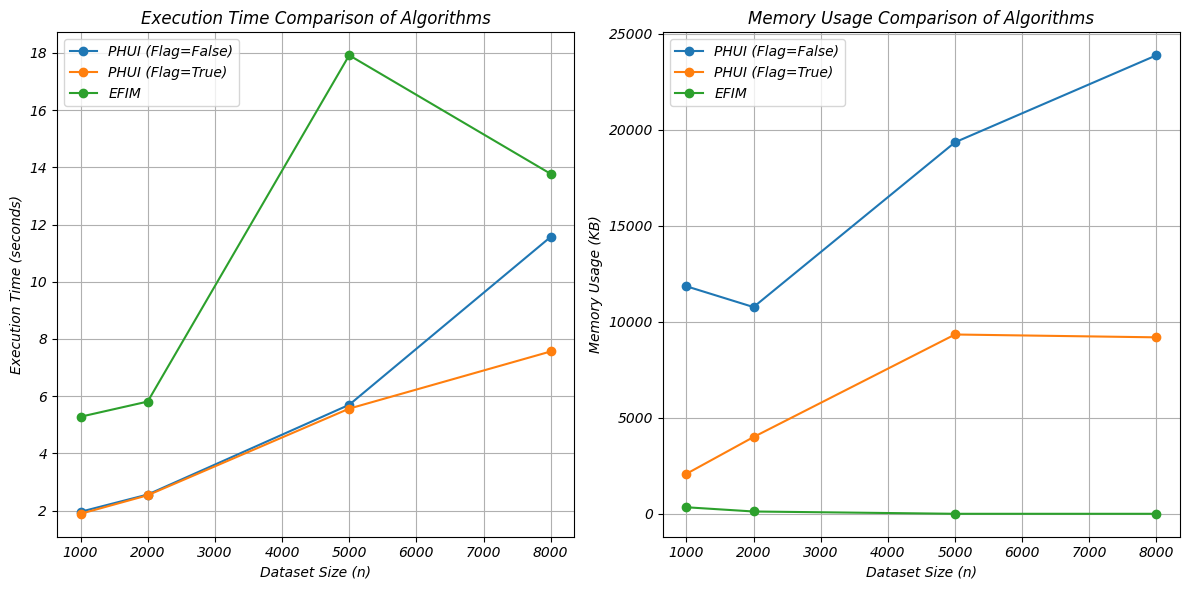

In [96]:
evaluate_mushroom_dataset(test_cases)

**Evaluate Connect Dataset:**

In [97]:
test_cases: list[TestCase] = [
    TestCase(5000, 50, 0.1, 1, 2000, 1, 2000),
    TestCase(10000, 50, 0.1, 1, 2000, 1, 2000),
    TestCase(20000, 50, 0.1, 1, 2000, 1, 2000),
    TestCase(40000, 50, 0.1, 1, 2000, 1, 2000),
    TestCase(70000, 50, 0.1, 1, 2000, 1, 2000),
]

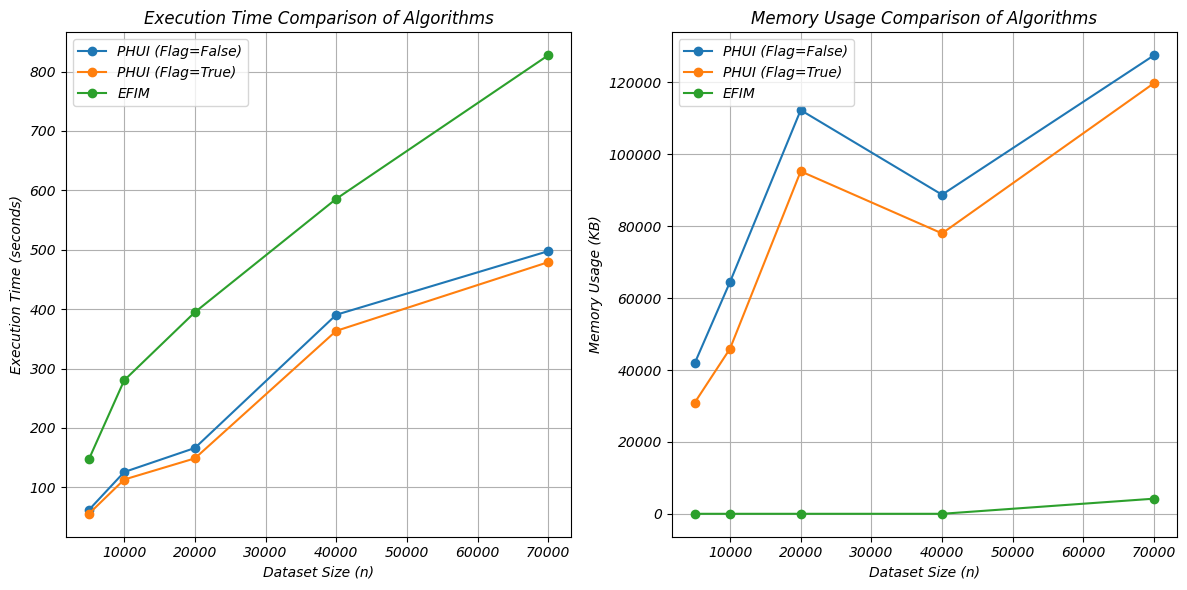

In [98]:
evaluate_connect_dataset(test_cases)

### **8. References**

1. Quang-Huy Duong, Bo Liao, Philippe Fournier-Viger, Thu-Lan Dam,  
   "An efficient algorithm for mining the top-k high utility itemsets using novel threshold raising and pruning strategies,"  
   *Knowledge-Based Systems*, vol. X, no. X, pp. XX-XX, 2016.  
   DOI: [10.1016/j.knosys.2016.04.016](https://doi.org/10.1016/j.knosys.2016.04.016)  
   [Full Article](./articles/1.pdf)

2. Wensheng Gan, Jerry Chun-Wei Lin, Philippe Fournier-Viger, Han-Chieh Chao, Vincent S. Tseng,  
   "Mining High-Utility Itemsets with Both Positive and Negative Unit Profits from Uncertain Databases,"  
   *Lecture Notes in Computer Science*, 2017.  
   DOI: [10.1007/978-3-319-57454-7_34](https://doi.org/10.1007/978-3-319-57454-7_34)  
   [Full Article](./articles/2.pdf)

3. Mohamed Ashraf, Tamer Abdelkader, Sherine Rady, Tarek F. Gharib,  
   "TKN: An efficient approach for discovering top-k high utility itemsets with positive or negative profits,"  
   *Information Sciences*, vol. 587, pp. 654–678, 2022.  
   DOI: [10.1016/j.ins.2021.12.024](https://doi.org/10.1016/j.ins.2021.12.024)  
   [Full Article](./articles/3.pdf)

4. Fuyin Lai, Xiaojie Zhang, Guoting Chen, Wensheng Gan,  
   "Mining periodic high-utility itemsets with both positive and negative utilities,"  
   *Engineering Applications of Artificial Intelligence*, vol. 123, pp. 106182, 2023.  
   DOI: [10.1016/j.engappai.2023.106182](https://doi.org/10.1016/j.engappai.2023.106182)  
   [Full Article](./articles/4.pdf)
   
5. N.T. Tung, Trinh D.D. Nguyen, Loan T.T. Nguyen, Bay Vo,  
   "An efficient method for mining High-Utility itemsets from unstable negative profit databases,"  
   *Expert Systems With Applications*, vol. 237, 2024, pp. 121489.  
   DOI: [10.1016/j.eswa.2023.121489](https://doi.org/10.1016/j.eswa.2023.121489)  
   [Full Article](./articles/5.pdf)

6. Zhiyang Li, Fengjuan Chen, Junfeng Wu, Zhaobin Liu, Weijiang Liu,  
   "Efficient weighted probabilistic frequent itemset mining in uncertain databases,"  
   *Expert Systems*, vol. X, no. X, 2020, e12551.  
   DOI: [10.1111/exsy.12551](https://doi.org/10.1111/exsy.12551)  
   [Full Article](./articles/6.pdf)